## This notebook compares concordance of centrolign SVs and horhap derived SVs using windows  

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [2]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [3]:
## This function reads in the concordance bed files 

def read_beds(folder_path, suffix):
    """
    Reads all BED files ending with 'triangles.100bp.bed' in the given folder
    and combines them into a single DataFrame with a calculated 'ratio' column.
    
    Parameters:
        folder_path (str): Path to the folder containing BED files.
        
    Returns:
        pd.DataFrame: Combined DataFrame with columns:
                      ['sample', 'window_start', 'window_end', 'centrolign_counts', 'horhap_counts', 'ratio']
    """
    
    all_dfs = []
    
    # Loop through files in folder
    for filename in os.listdir(folder_path):
        if filename.endswith(suffix):
            file_path = os.path.join(folder_path, filename)
            
            # Read the BED file
            df = pd.read_csv(
                file_path,
                sep="\t",            # assuming tab-delimited
                header=None,
                names=["sample", "window_start", "window_end", "centrolign_counts", "horhap_counts"]
            )
            # Determine the "other" sample in the file
            unique_samples = df["sample"].unique()
            if len(unique_samples) == 1:
                # Only one sample, set sample2 to None
                df["sample2"] = None
            else:
                # Create a mapping from sample to the other sample
                sample_map = {s: [o for o in unique_samples if o != s][0] for s in unique_samples}
                df["sample2"] = df["sample"].map(sample_map)
            
            # Compute ratio safely
            df["ratio"] = df.apply(
                lambda row: row["centrolign_counts"] / row["horhap_counts"]
                if row["centrolign_counts"] != 0 and row["horhap_counts"] != 0
                else 0,
                axis=1
            )
            
            all_dfs.append(df)
    
    # Concatenate all DataFrames
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        # Return empty DataFrame with correct columns if no files found
        return pd.DataFrame(columns=["sample","sample2", "window_start", "window_end", 
                                     "centrolign_counts", "horhap_counts", "ratio"])


### 100bp windows, just triangles. Plotting each window separately

In [4]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "triangles.100bp.bed"
triangles_100bp_df = read_beds(folder,suffix)
triangles_100bp_df["chr"]="chr12"
print(triangles_100bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00290.1      34653281    34657558               4077              0   
1  HG00290.1      34680631    34681867                  0           1036   
2  HG00290.1      34727166    34749346              14598          15621   
3  HG00290.1      34750258    34784073              21054          24337   
4  HG00290.1      34795428    34807027               7813           7492   

     sample2     ratio    chr  
0  HG01358.1  0.000000  chr12  
1  HG01358.1  0.000000  chr12  
2  HG01358.1  0.934511  chr12  
3  HG01358.1  0.865103  chr12  
4  HG01358.1  1.042846  chr12  


In [5]:
## merge with all pairs distances 
triangles_100bp_df = triangles_100bp_df.rename(columns={"sample": "sample1"})

triangles_100bp_df_merged = (
    triangles_100bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

triangles_100bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist
0,HG00290.1,34653281,34657558,4077,0,HG01358.1,0.000000,chr12,0.513215
1,HG00290.1,34680631,34681867,0,1036,HG01358.1,0.000000,chr12,0.513215
2,HG00290.1,34727166,34749346,14598,15621,HG01358.1,0.934511,chr12,0.513215
3,HG00290.1,34750258,34784073,21054,24337,HG01358.1,0.865103,chr12,0.513215
4,HG00290.1,34795428,34807027,7813,7492,HG01358.1,1.042846,chr12,0.513215


In [6]:
denom = triangles_100bp_df_merged["centrolign_counts"] + triangles_100bp_df_merged["horhap_counts"]

triangles_100bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    triangles_100bp_df_merged["centrolign_counts"] / denom,
    0
)
triangles_100bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00290.1,34653281,34657558,4077,0,HG01358.1,0.000000,chr12,0.513215,1.000000
1,HG00290.1,34680631,34681867,0,1036,HG01358.1,0.000000,chr12,0.513215,0.000000
2,HG00290.1,34727166,34749346,14598,15621,HG01358.1,0.934511,chr12,0.513215,0.483074
3,HG00290.1,34750258,34784073,21054,24337,HG01358.1,0.865103,chr12,0.513215,0.463836
4,HG00290.1,34795428,34807027,7813,7492,HG01358.1,1.042846,chr12,0.513215,0.510487


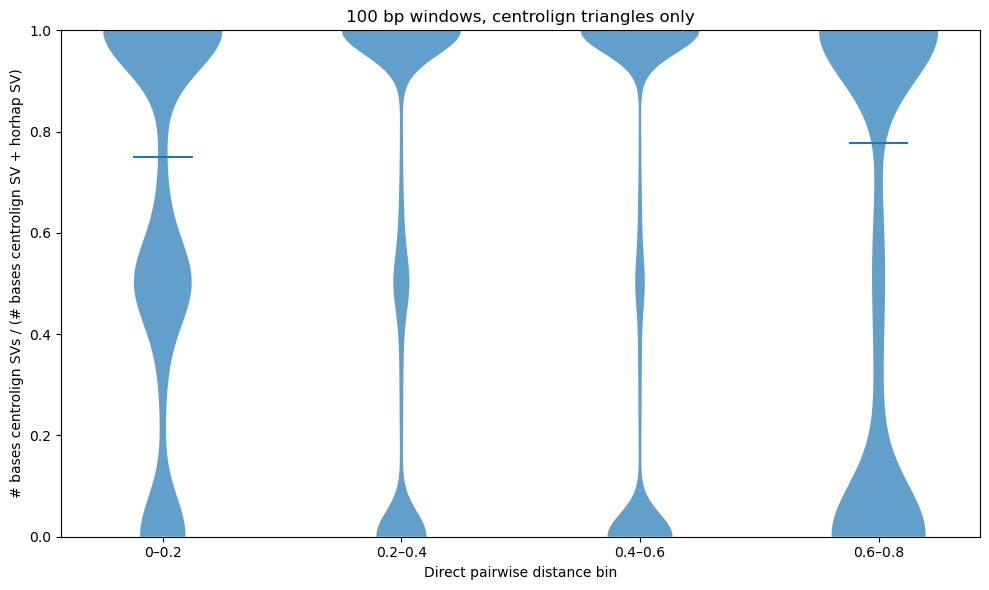

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = triangles_100bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SV)")
plt.title("100 bp windows, centrolign triangles only")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [7]:
### Calculate the average concordance per sample 

# create an order-independent pair column
triangles_100bp_df_merged["sample_pair"] = triangles_100bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_triangles_100bp = (
    triangles_100bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_triangles_100bp)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.463442              0.534728
1     (HG00099.1, HG00128.1)      0.652857              0.118052
2     (HG00099.1, HG00133.1)      0.550066              0.042255
3     (HG00099.1, HG00140.2)      0.650023              0.121332
4     (HG00099.1, HG00232.2)      0.645767              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.697483              0.415930
1481  (NA20905.1, NA21106.2)      0.629851              0.373868
1482  (NA21102.2, NA21106.1)      0.701315              0.424940
1483  (NA21102.2, NA21106.2)      0.680566              0.136764
1484  (NA21106.1, NA21106.2)      0.705731              0.396133

[1485 rows x 3 columns]


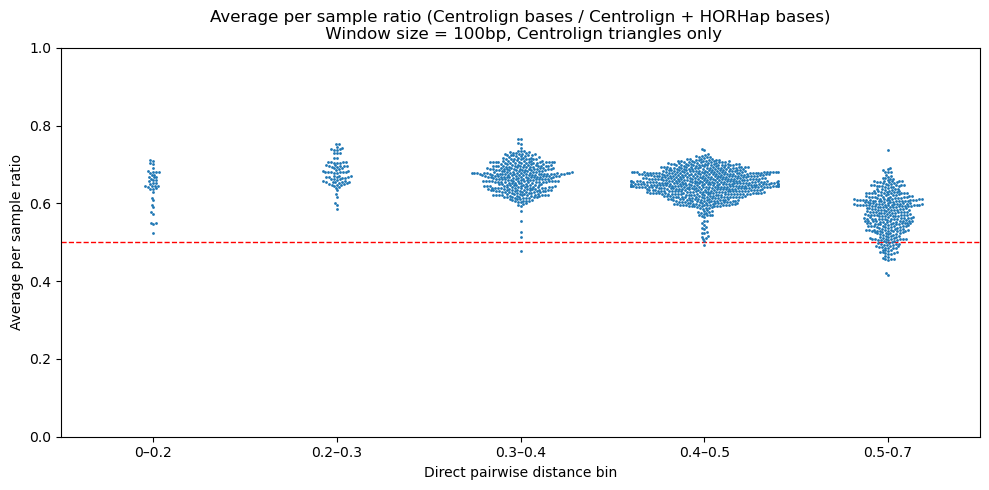

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_triangles_100bp["dist_bin"] = pd.cut(
    avg_cen_prop_triangles_100bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_triangles_100bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average per sample ratio")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 100bp, Centrolign triangles only")
plt.tight_layout()
plt.show()


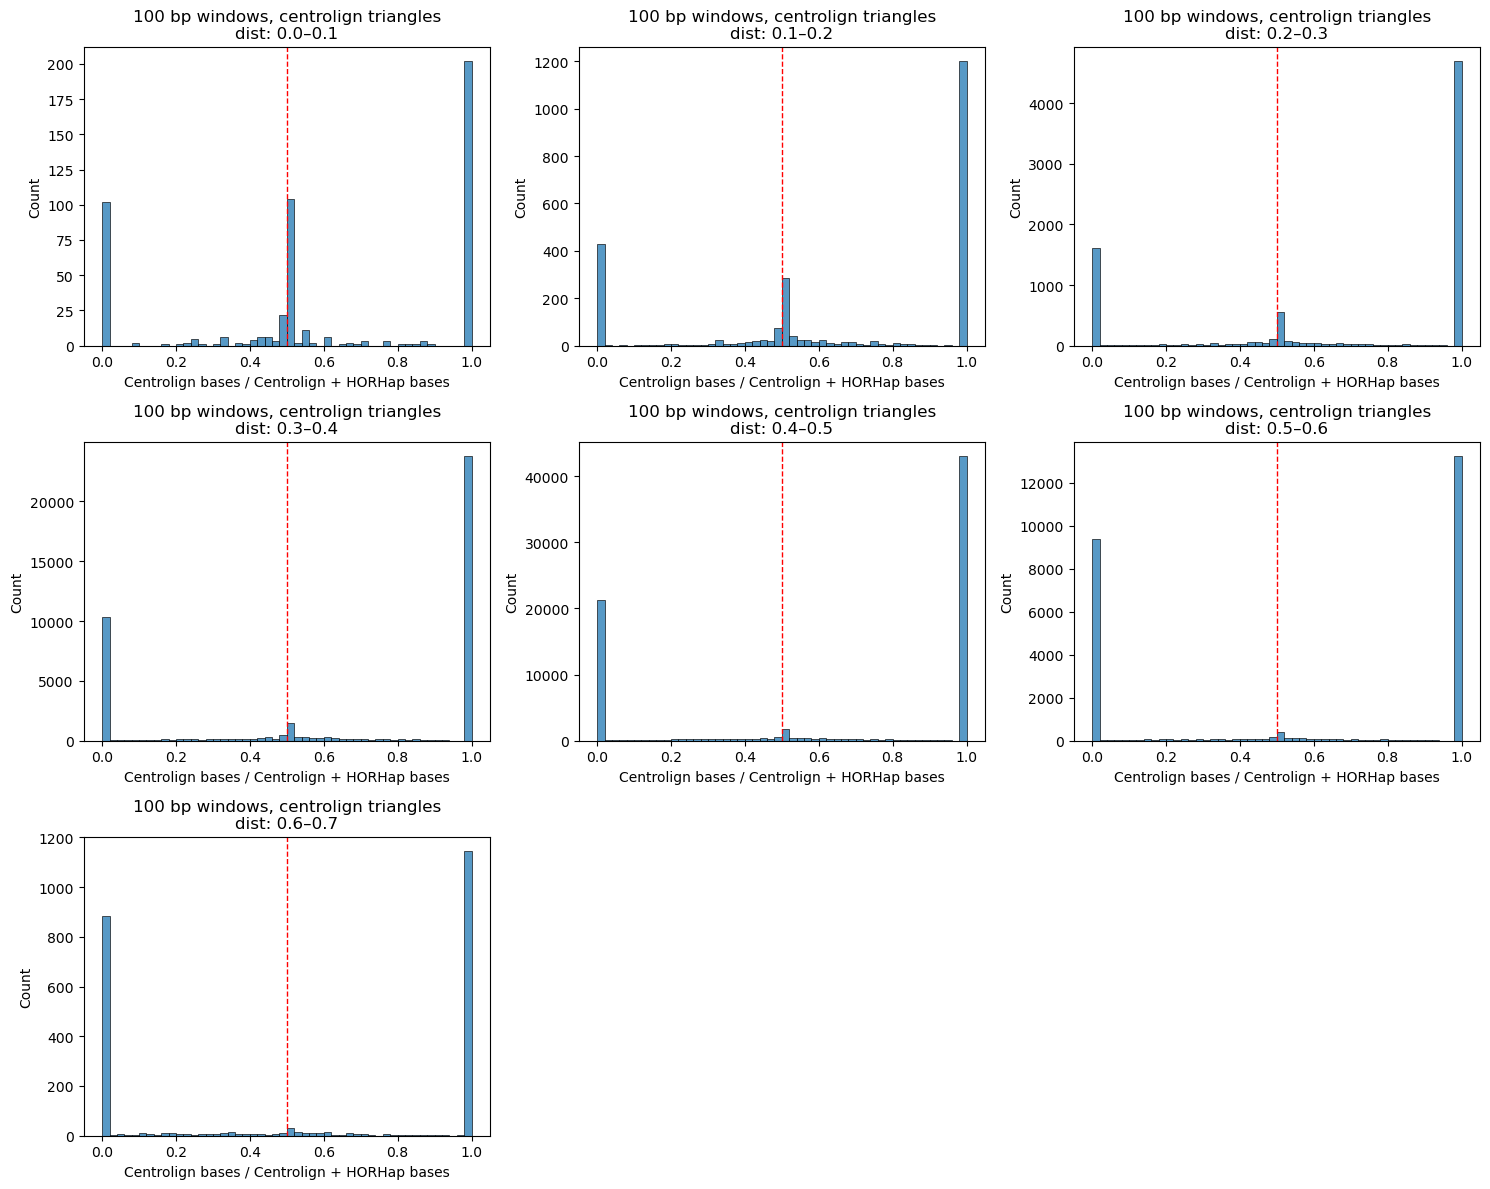

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = triangles_100bp_df_merged[
        (triangles_100bp_df_merged["direct_pairwise_dist"] >= low) &
        (triangles_100bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"100 bp windows, centrolign triangles\ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### 100 bp windows, all SVs. Plotting concordance for each window separately 

In [35]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "all_SVs.100bp.bed"
all_svs_100bp_df = read_beds(folder,suffix)
all_svs_100bp_df["chr"]="chr12"
print(all_svs_100bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG01109.1      34766195    34767754               1359              0   
1  HG01109.1      34867956    34869193                  0           1037   
2  HG01109.1      34872067    34875664               3397              0   
3  HG01109.1      34897963    34905639               7476              0   
4  HG01109.1      34913485    34917082               3397              0   

     sample2  ratio    chr  
0  HG01940.2    0.0  chr12  
1  HG01940.2    0.0  chr12  
2  HG01940.2    0.0  chr12  
3  HG01940.2    0.0  chr12  
4  HG01940.2    0.0  chr12  


In [36]:
## merge with all pairs distances 

all_svs_100bp_df = all_svs_100bp_df.rename(columns={"sample": "sample1"})

all_svs_100bp_df_merged = (
    all_svs_100bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

all_svs_100bp_df_merged.head()

denom = all_svs_100bp_df_merged["centrolign_counts"] + all_svs_100bp_df_merged["horhap_counts"]

all_svs_100bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    all_svs_100bp_df_merged["centrolign_counts"] / denom,
    0
)
all_svs_100bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG01109.1,34766195,34767754,1359,0,HG01940.2,0.0,chr12,0.23066,1.0
1,HG01109.1,34867956,34869193,0,1037,HG01940.2,0.0,chr12,0.23066,0.0
2,HG01109.1,34872067,34875664,3397,0,HG01940.2,0.0,chr12,0.23066,1.0
3,HG01109.1,34897963,34905639,7476,0,HG01940.2,0.0,chr12,0.23066,1.0
4,HG01109.1,34913485,34917082,3397,0,HG01940.2,0.0,chr12,0.23066,1.0


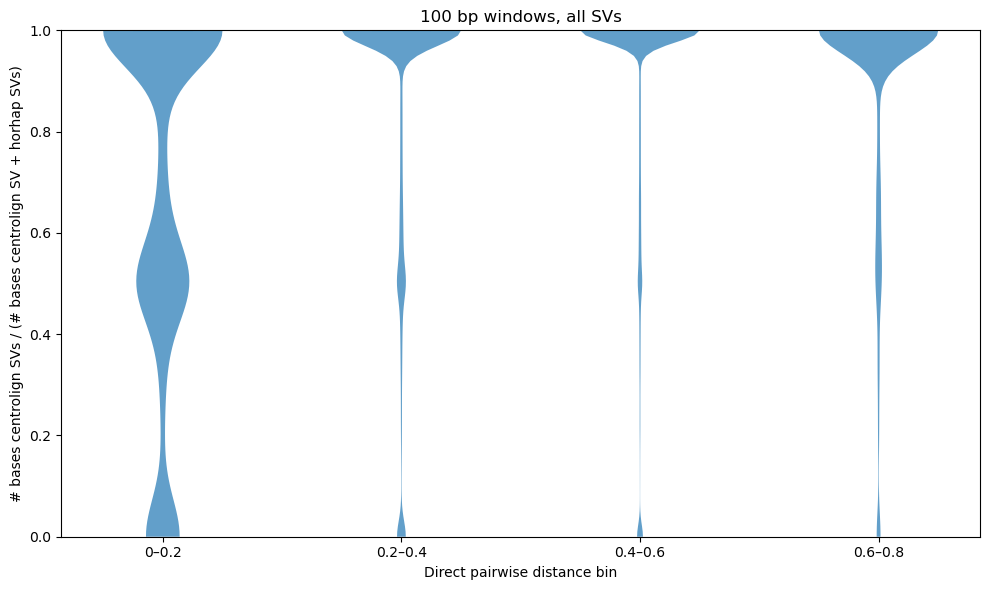

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = all_svs_100bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("100 bp windows, all SVs")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [38]:
### Calculate the average concordance per sample 

# create an order-independent pair column
all_svs_100bp_df_merged["sample_pair"] = all_svs_100bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_all_svs_100bp = (
    all_svs_100bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_all_svs_100bp)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.914358              0.534728
1     (HG00099.1, HG00128.1)      0.678380              0.118052
2     (HG00099.1, HG00133.1)      0.559595              0.042255
3     (HG00099.1, HG00140.2)      0.695287              0.121332
4     (HG00099.1, HG00232.2)      0.887120              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.874201              0.415930
1481  (NA20905.1, NA21106.2)      0.888610              0.373868
1482  (NA21102.2, NA21106.1)      0.890398              0.424940
1483  (NA21102.2, NA21106.2)      0.685495              0.136764
1484  (NA21106.1, NA21106.2)      0.896082              0.396133

[1485 rows x 3 columns]


/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


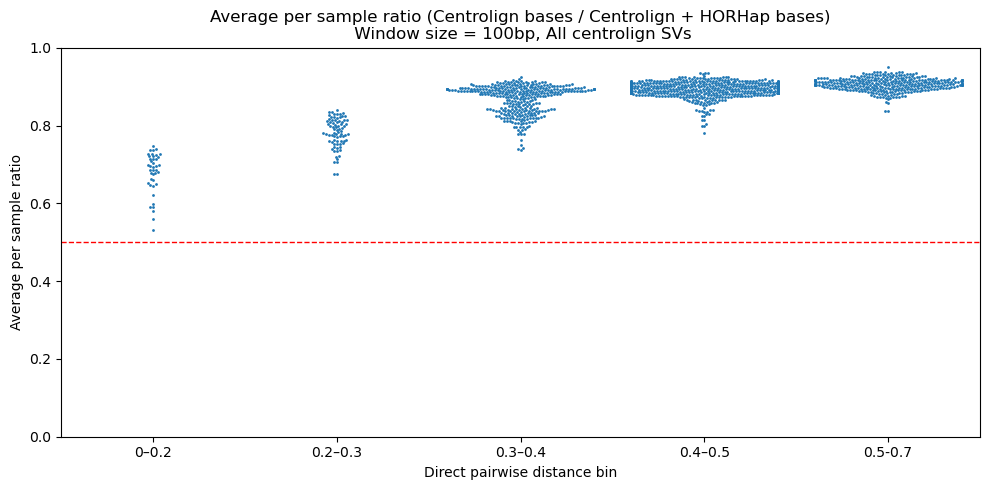

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_all_svs_100bp["dist_bin"] = pd.cut(
    avg_cen_prop_all_svs_100bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_all_svs_100bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average per sample ratio")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 100bp, All centrolign SVs")
plt.tight_layout()
plt.show()


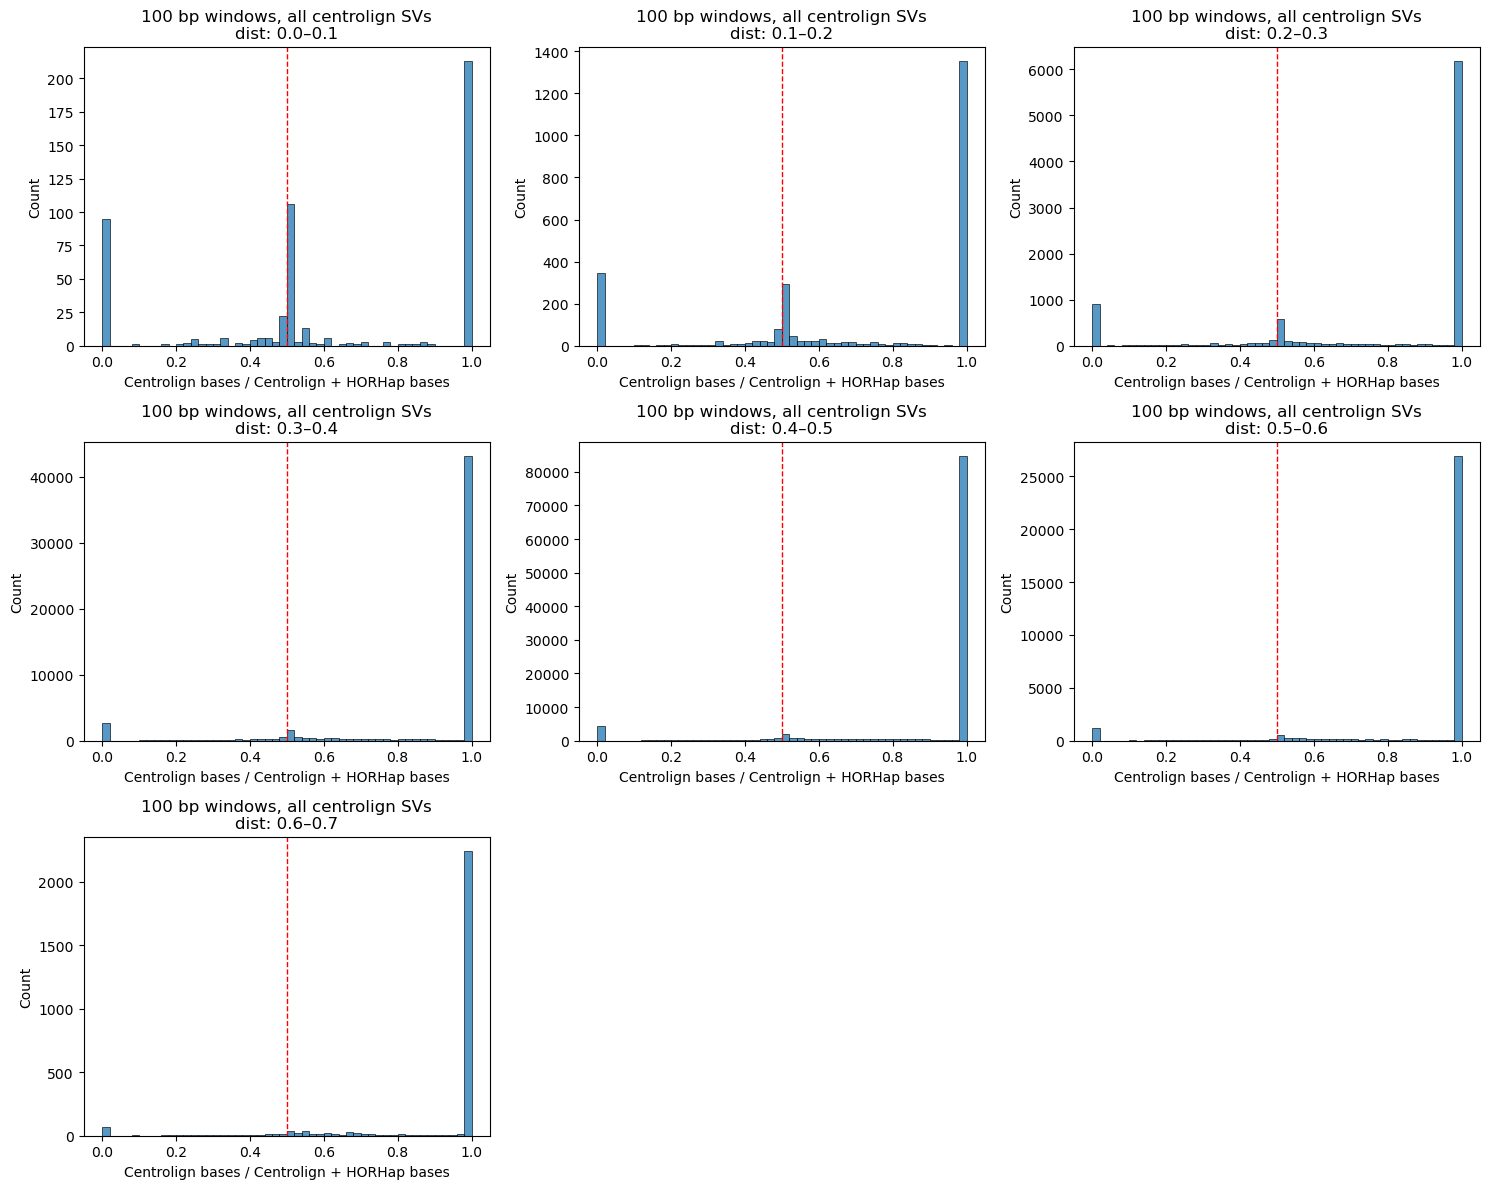

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = all_svs_100bp_df_merged[
        (all_svs_100bp_df_merged["direct_pairwise_dist"] >= low) &
        (all_svs_100bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"100 bp windows, all centrolign SVs\ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()



### 1000 bp windows, all SVs 

In [43]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "all_SVs.1000bp.bed"
all_svs_1000bp_df = read_beds(folder,suffix)
all_svs_1000bp_df["chr"]="chr12"
print(all_svs_1000bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00126.2      34708991    34715618               3737              0   
1  HG00126.2      34719721    34727491               5770              0   
2  HG00126.2      34735738    34745966               8228              0   
3  HG00126.2      34747038    34757342               6479              0   
4  HG00126.2      34758052    34760538                486              0   

     sample2  ratio    chr  
0  HG00329.2    0.0  chr12  
1  HG00329.2    0.0  chr12  
2  HG00329.2    0.0  chr12  
3  HG00329.2    0.0  chr12  
4  HG00329.2    0.0  chr12  


In [45]:
## merge with all pairs distances 

all_svs_1000bp_df = all_svs_1000bp_df.rename(columns={"sample": "sample1"})

all_svs_1000bp_df_merged = (
    all_svs_1000bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

all_svs_1000bp_df_merged.head()

denom = all_svs_1000bp_df_merged["centrolign_counts"] + all_svs_1000bp_df_merged["horhap_counts"]

all_svs_1000bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    all_svs_1000bp_df_merged["centrolign_counts"] / denom,
    0
)
all_svs_1000bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00126.2,34708991,34715618,3737,0,HG00329.2,0.0,chr12,0.562033,1.0
1,HG00126.2,34719721,34727491,5770,0,HG00329.2,0.0,chr12,0.562033,1.0
2,HG00126.2,34735738,34745966,8228,0,HG00329.2,0.0,chr12,0.562033,1.0
3,HG00126.2,34747038,34757342,6479,0,HG00329.2,0.0,chr12,0.562033,1.0
4,HG00126.2,34758052,34760538,486,0,HG00329.2,0.0,chr12,0.562033,1.0


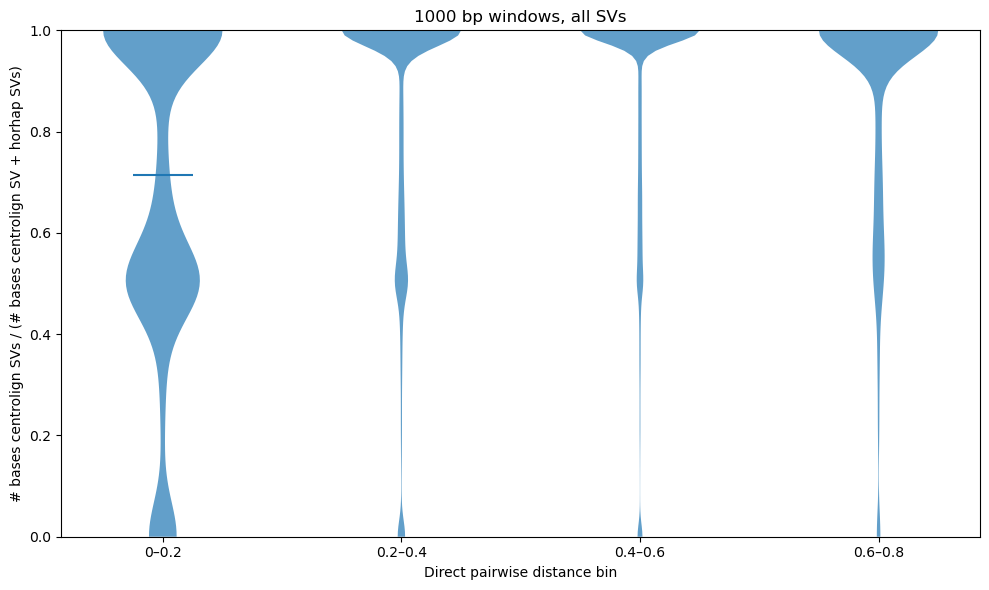

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = all_svs_1000bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("1000 bp windows, all SVs")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

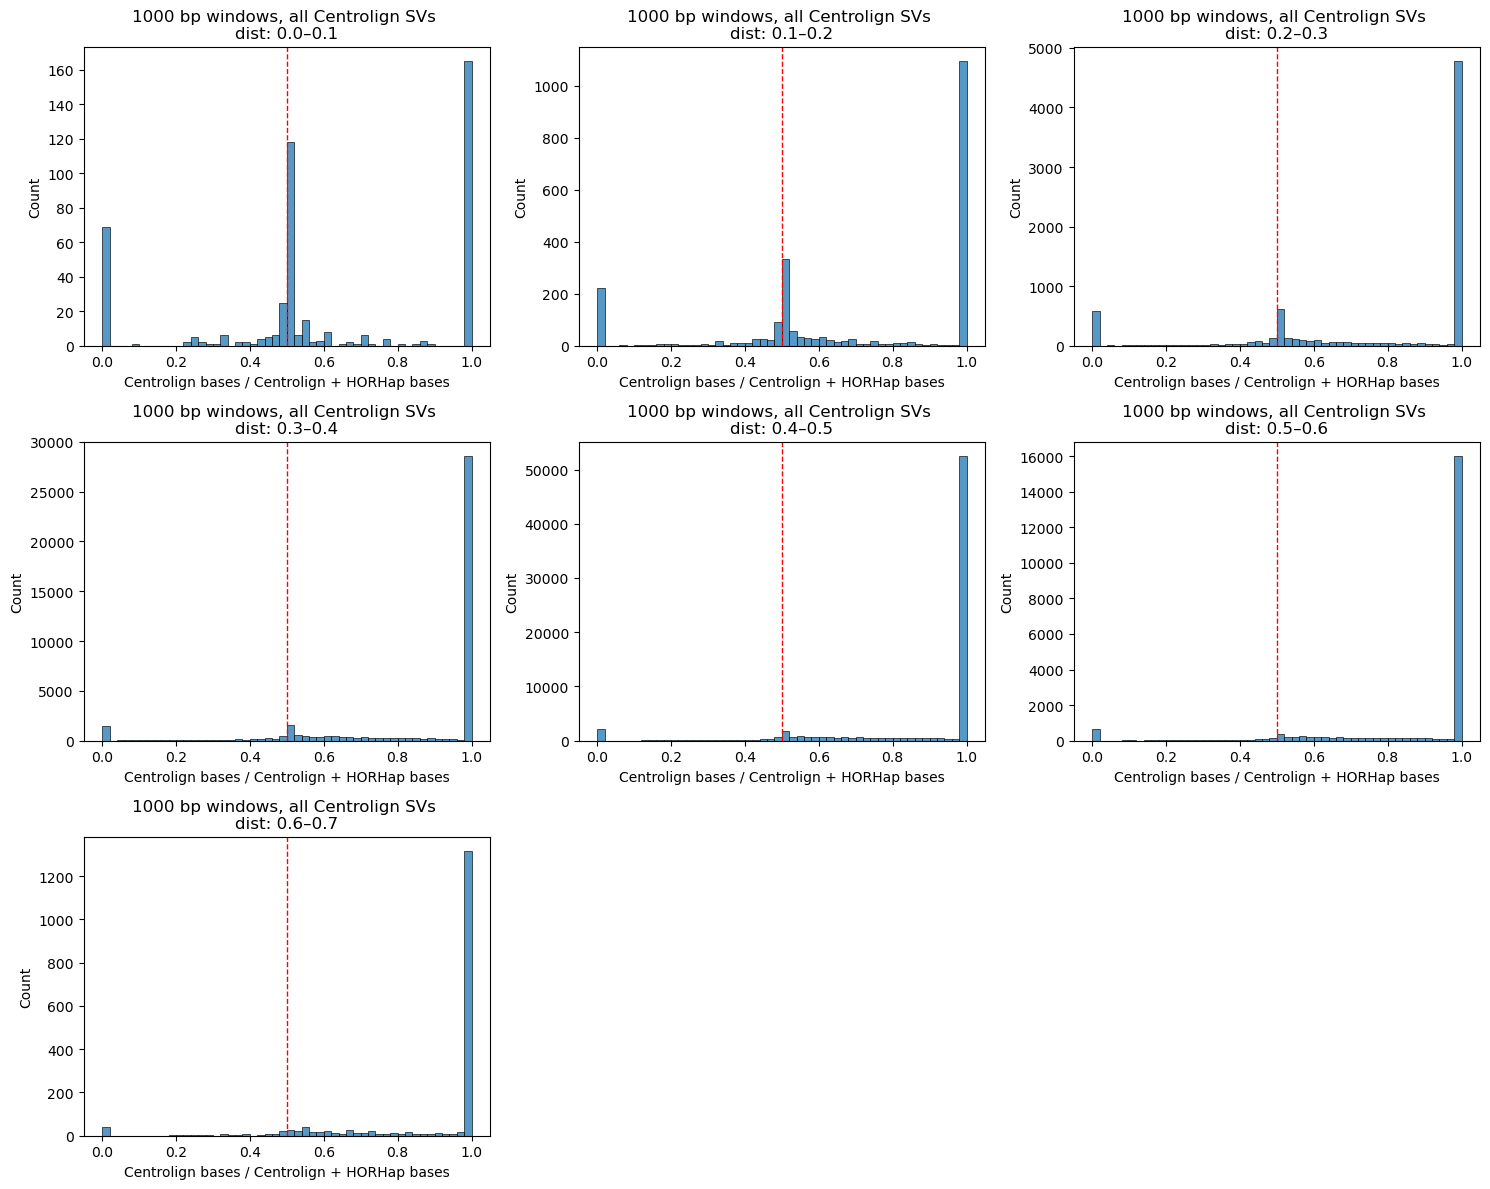

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = all_svs_1000bp_df_merged[
        (all_svs_1000bp_df_merged["direct_pairwise_dist"] >= low) &
        (all_svs_1000bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"1000 bp windows, all Centrolign SVs \ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [47]:
### Calculate the average concordance per sample 

# create an order-independent pair column
all_svs_1000bp_df_merged["sample_pair"] = all_svs_1000bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_all_svs_1000bp = (
    all_svs_1000bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_all_svs_1000bp)

                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.886465              0.534728
1     (HG00099.1, HG00128.1)      0.674608              0.118052
2     (HG00099.1, HG00133.1)      0.547987              0.042255
3     (HG00099.1, HG00140.2)      0.694322              0.121332
4     (HG00099.1, HG00232.2)      0.876734              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.874413              0.415930
1481  (NA20905.1, NA21106.2)      0.885123              0.373868
1482  (NA21102.2, NA21106.1)      0.876503              0.424940
1483  (NA21102.2, NA21106.2)      0.686086              0.136764
1484  (NA21106.1, NA21106.2)      0.878838              0.396133

[1485 rows x 3 columns]


/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


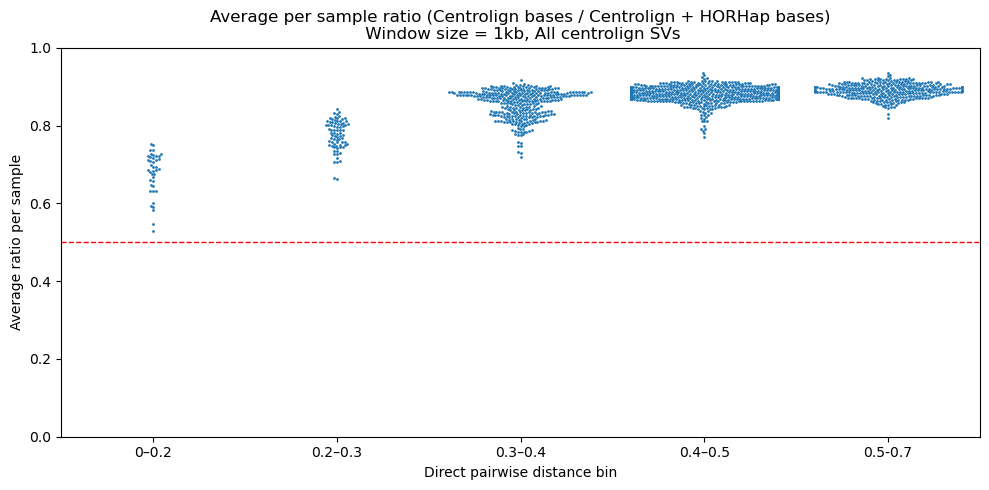

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_all_svs_1000bp["dist_bin"] = pd.cut(
    avg_cen_prop_all_svs_1000bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_all_svs_1000bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average ratio per sample")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 1kb, All centrolign SVs")
plt.tight_layout()
plt.show()

### 1000 bp windows, just triangles

In [8]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "triangles.1000bp.bed"
triangles_1000bp_df = read_beds(folder,suffix)
triangles_1000bp_df["chr"]="chr12"
print(triangles_1000bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00232.2      34760397    34778865              14263          10881   
1  HG00232.2      34784758    34788116               1358              0   
2  HG00232.2      34804224    34810636               4412              0   
3  HG00232.2      34815692    34819051               1359              0   
4  HG00232.2      34845760    34848436                676              0   

     sample2     ratio    chr  
0  HG01106.1  1.310817  chr12  
1  HG01106.1  0.000000  chr12  
2  HG01106.1  0.000000  chr12  
3  HG01106.1  0.000000  chr12  
4  HG01106.1  0.000000  chr12  


In [9]:
## merge with all pairs distances 

triangles_1000bp_df = triangles_1000bp_df.rename(columns={"sample": "sample1"})

triangles_1000bp_df_merged = (
    triangles_1000bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

triangles_1000bp_df_merged.head()

denom = triangles_1000bp_df_merged["centrolign_counts"] + triangles_1000bp_df_merged["horhap_counts"]

triangles_1000bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    triangles_1000bp_df_merged["centrolign_counts"] / denom,
    0
)
triangles_1000bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00232.2,34760397,34778865,14263,10881,HG01106.1,1.310817,chr12,0.61767,0.567253
1,HG00232.2,34784758,34788116,1358,0,HG01106.1,0.000000,chr12,0.61767,1.000000
2,HG00232.2,34804224,34810636,4412,0,HG01106.1,0.000000,chr12,0.61767,1.000000
3,HG00232.2,34815692,34819051,1359,0,HG01106.1,0.000000,chr12,0.61767,1.000000
4,HG00232.2,34845760,34848436,676,0,HG01106.1,0.000000,chr12,0.61767,1.000000


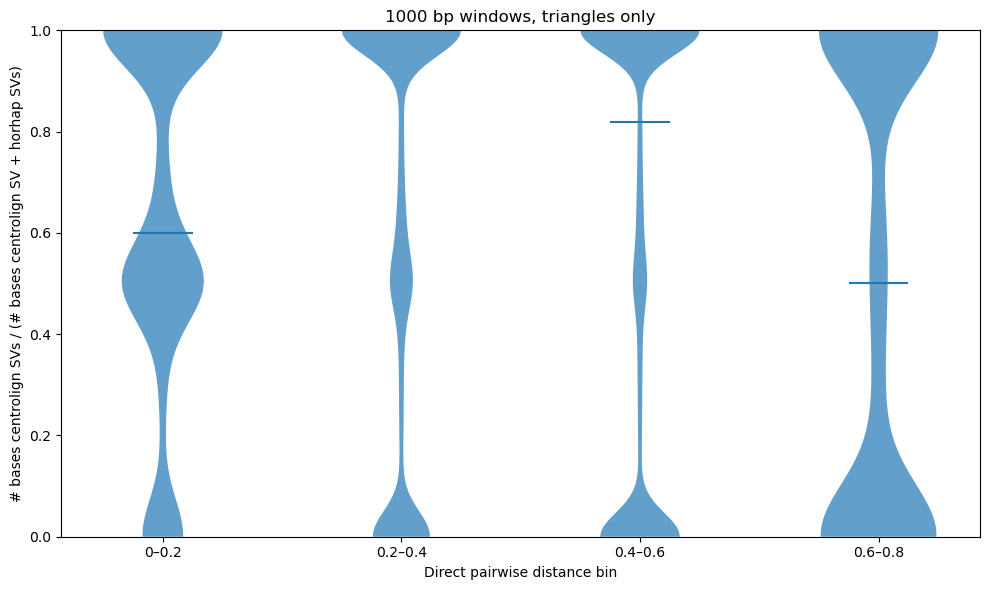

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = triangles_1000bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("1000 bp windows, triangles only")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

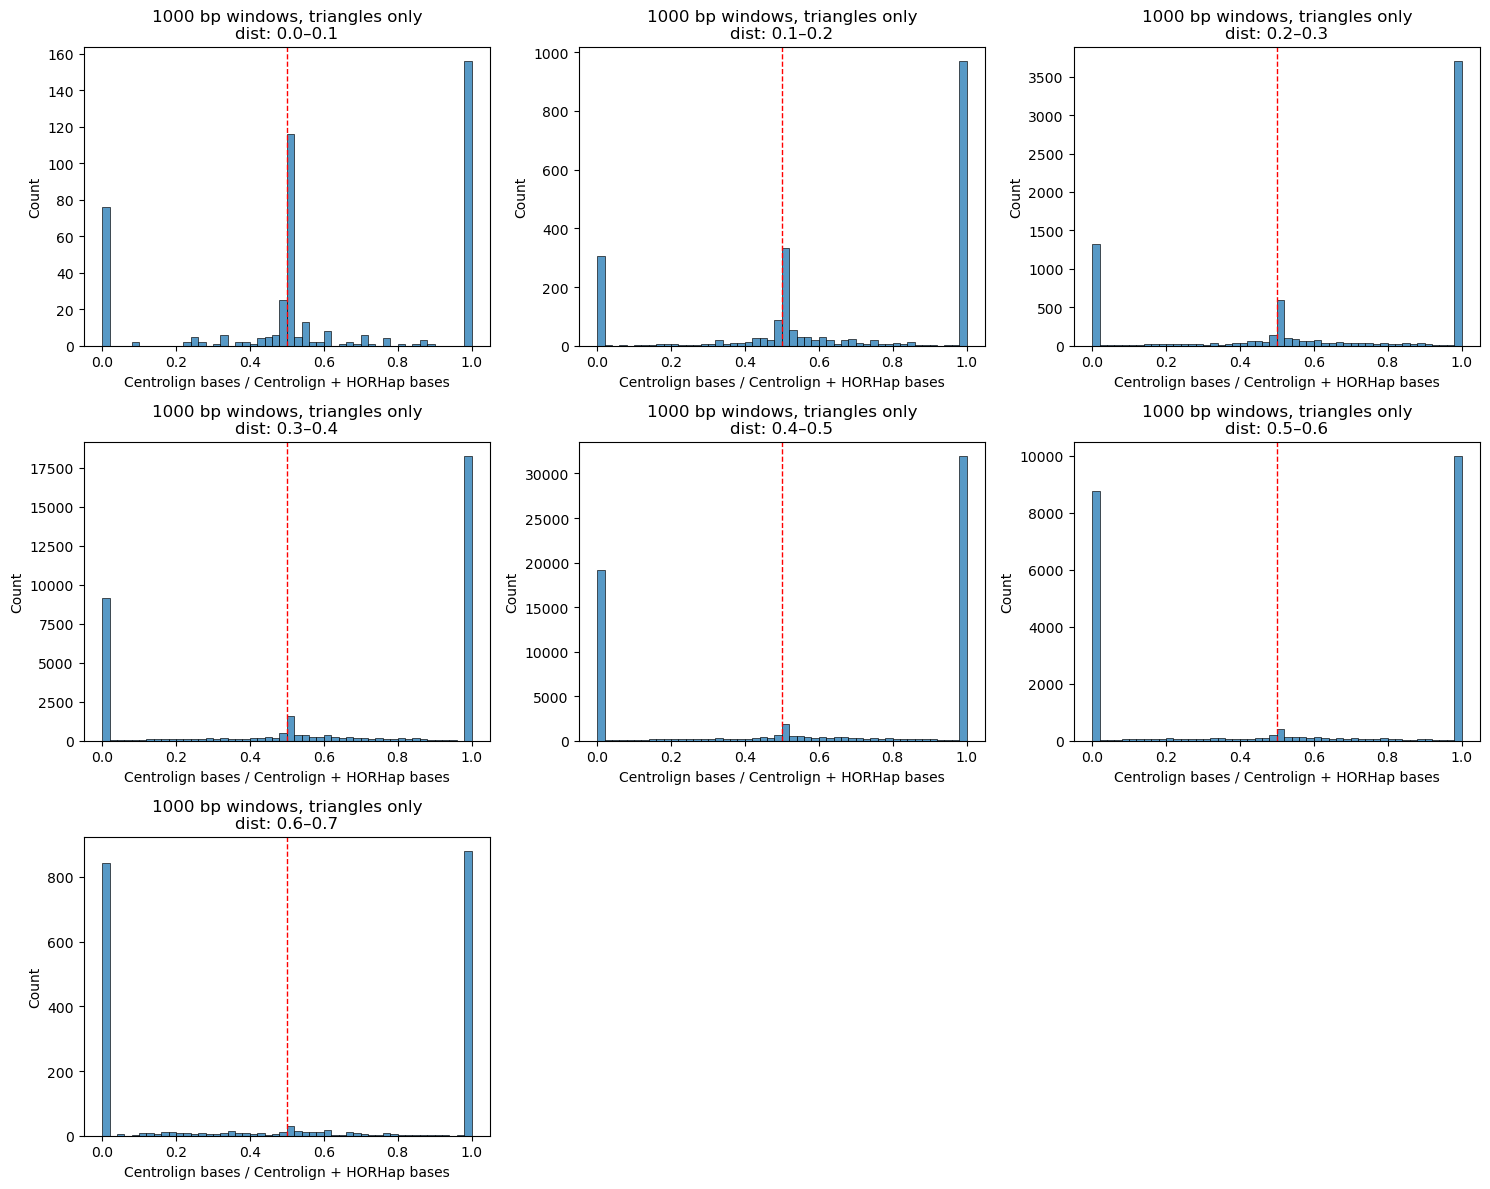

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = triangles_1000bp_df_merged[
        (triangles_1000bp_df_merged["direct_pairwise_dist"] >= low) &
        (triangles_1000bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"1000 bp windows, triangles only\ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
### Calculate the average concordance per sample 

# create an order-independent pair column
triangles_1000bp_df_merged["sample_pair"] = triangles_1000bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_triangles_1000bp = (
    triangles_1000bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_triangles_1000bp)

                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.414615              0.534728
1     (HG00099.1, HG00128.1)      0.648691              0.118052
2     (HG00099.1, HG00133.1)      0.535430              0.042255
3     (HG00099.1, HG00140.2)      0.649935              0.121332
4     (HG00099.1, HG00232.2)      0.601518              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.671370              0.415930
1481  (NA20905.1, NA21106.2)      0.610960              0.373868
1482  (NA21102.2, NA21106.1)      0.668211              0.424940
1483  (NA21102.2, NA21106.2)      0.680939              0.136764
1484  (NA21106.1, NA21106.2)      0.670149              0.396133

[1485 rows x 3 columns]


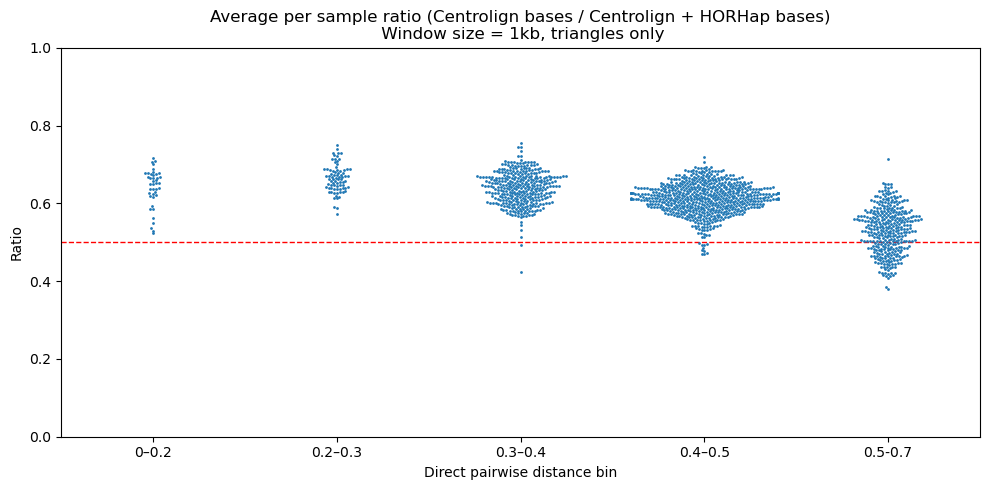

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_triangles_1000bp["dist_bin"] = pd.cut(
    avg_cen_prop_triangles_1000bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_triangles_1000bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Ratio")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 1kb, triangles only")
plt.tight_layout()
plt.show()

In [60]:
# Get samples with highest cen_prop values
top3 = (
    avg_cen_prop_triangles_1000bp[avg_cen_prop_triangles_1000bp["direct_pairwise_dist"] < 0.2]
    .sort_values("avg_cen_prop", ascending=False)
    .head(3)
)

print(top3)



                 sample_pair  avg_cen_prop  direct_pairwise_dist dist_bin
1248  (HG02280.2, NA20809.2)      0.716225              0.144713    0–0.2
436   (HG00290.2, HG03710.1)      0.708858              0.188366    0–0.2
642   (HG00735.2, HG02280.2)      0.706917              0.149905    0–0.2


In [11]:
top3 = (
    avg_cen_prop_triangles_1000bp[
        (avg_cen_prop_triangles_1000bp["direct_pairwise_dist"] < 0.2) &
        (avg_cen_prop_triangles_1000bp["avg_cen_prop"] >= 0.5) &
        (avg_cen_prop_triangles_1000bp["avg_cen_prop"] <= 0.55)
    ]
    .sort_values("avg_cen_prop", ascending=False)
    .head(10)
)

print(top3)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
659   (HG00735.2, NA20809.2)      0.548272              0.040491
2     (HG00099.1, HG00133.1)      0.535430              0.042255
1301  (HG02698.1, HG03784.2)      0.529980              0.168366
25    (HG00099.1, HG01891.1)      0.522803              0.037073


### New approach: Calculating an F-1 score 

In [3]:
import os
import csv

def parse_bed_files(folder):
    """
    Returns a dict:
      key = tuple(sorted([sample1, sample2]))
      value = full path to bed file
    """
    beds = {}
    for fname in os.listdir(folder):
        if not fname.endswith(".bed"):
            continue

        base = os.path.splitext(fname)[0]
        parts = base.split("_")
        if len(parts) != 2:
            continue  # skip unexpected filenames

        key = tuple(sorted(parts))
        beds[key] = os.path.join(folder, fname)

    return beds


def match_beds(path1, path2, output_csv):
    beds1 = parse_bed_files(path1)
    beds2 = parse_bed_files(path2)

    # Union of all sample pairings
    all_keys = set(beds1) | set(beds2)

    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["path1_bed", "path2_bed"])

        for key in sorted(all_keys):
            bed1 = beds1.get(key, "NO_MATCH")
            bed2 = beds2.get(key, "NO_MATCH")
            writer.writerow([bed1, bed2])


In [30]:
## get list of horhap and centrolign beds matched by sample pair

path1="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/SV_beds_asm_coords"
path2="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/fedor_horHap_SV_beds"

output_csv = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/matched_beds.csv"
match_beds(path1, path2, output_csv)

# max dist 3000bp, size fraction of 0.5, no large SV masking 

In [4]:
import os
import pandas as pd

def load_summary_files(directory):
    dfs = []

    for fname in os.listdir(directory):
        if not fname.endswith("_summary.txt"):
            continue

        # Remove suffix and split samples
        base = fname.replace("_summary.txt", "")
        parts = base.split("_")

        if len(parts) != 2:
            continue  # skip unexpected filenames

        sample1, sample2 = parts

        filepath = os.path.join(directory, fname)

        # Read summary file
        df = pd.read_csv(filepath, sep=None, engine="python")
        df["sample1"] = sample1
        df["sample2"] = sample2

        dfs.append(df)

    if not dfs:
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


In [32]:
directory = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/sv_compare/md3k_msf0.5/"
df = load_summary_files(directory)
df["chr"]="chr12"

def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df
df = make_sorted_pair(df)
all_pairs_dist_df = make_sorted_pair(all_pairs_dist_df)

merged_df = df.merge(
    all_pairs_dist_df,
    on=["sample_pair", "chr"],
    how="inner"   # or "left" depending on your intent
)

merged_df = merged_df.drop(columns=["sample_pair"])

print(merged_df)

             P         R        F1  sample1_x  sample2_x    chr  sample1_y  \
0     0.439252  0.162907  0.237669  HG03688.1  NA19835.1  chr12  HG03688.1   
1     0.387755  0.155263  0.221739  HG02280.2  HG01192.1  chr12  HG01192.1   
2     0.504762  0.161804  0.245054  HG01258.2  HG01109.1  chr12  HG01109.1   
3     0.505376  0.183417  0.269151  HG01940.1  HG02698.1  chr12  HG01940.1   
4     0.132653  0.061033  0.083601  HG01993.2  HG02559.2  chr12  HG01993.2   
...        ...       ...       ...        ...        ...    ...        ...   
1480  0.316239  0.201320  0.246021  HG00329.2  HG02559.2  chr12  HG00329.2   
1481  0.365385  0.185075  0.245698  HG00140.2  HG00320.1  chr12  HG00140.2   
1482  0.378378  0.190909  0.253776  HG01258.2  HG00126.2  chr12  HG00126.2   
1483  0.444444  0.096515  0.158590  HG03688.1  NA20809.2  chr12  HG03688.1   
1484  0.592593  0.368794  0.454645  HG00290.1  HG01993.2  chr12  HG00290.1   

      sample2_y  direct_pairwise_dist  
0     NA19835.1        

/data/tmp/ipykernel_1800872/3487393392.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/data/tmp/ipykernel_1800872/3487393392.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


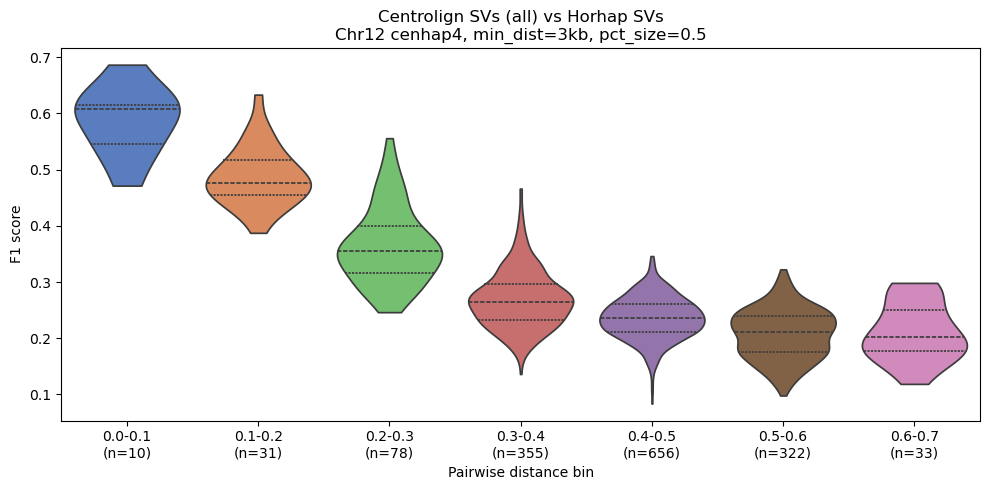

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Create bins for pairwise distance (0–0.7)
bins = np.arange(0, 0.8, 0.1)  # 0.0, 0.1, ..., 0.7
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

merged_df["dist_bin"] = pd.cut(
    merged_df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 2️⃣ Count number of rows per bin (preserve bin order)
bin_counts = (
    merged_df["dist_bin"]
    .value_counts()
    .reindex(labels, fill_value=0)
)

# 3️⃣ Plot violin plot
plt.figure(figsize=(10,5))
ax = sns.violinplot(
    data=merged_df,
    x="dist_bin",
    y="F1",
    inner="quartile",   # median + quartiles
    cut=0,              # limit tails to data range
    palette="muted"
)

# 4️⃣ Replace x-axis labels with bin + count
xtick_labels = [
    f"{label}\n(n={bin_counts[label]})"
    for label in labels
]
ax.set_xticklabels(xtick_labels)

# 5️⃣ Labels and formatting
ax.set_xlabel("Pairwise distance bin")
ax.set_ylabel("F1 score")
ax.set_title(
    "Centrolign SVs (all) vs Horhap SVs\n"
    "Chr12 cenhap4, min_dist=3kb, pct_size=0.5"
)

plt.tight_layout()
plt.show()



In [34]:
# Get pairs with lowest F-1 scores for bin 0-0.2
# Filter for the specific bin
bin_df = merged_df[merged_df["dist_bin"] == "0.1-0.2"]

# Get 5 rows with the lowest F1
lowest_f1_rows = bin_df.nsmallest(5, "F1")

print(lowest_f1_rows)


             P         R        F1  sample1_x  sample2_x    chr  sample1_y  \
1458  0.557895  0.296875  0.387531  HG00290.2  HG01940.1  chr12  HG00290.2   
175   0.594059  0.325123  0.420248  HG00290.2  HG02004.1  chr12  HG00290.2   
1092  0.573770  0.342105  0.428639  HG03654.2  HG01358.1  chr12  HG01358.1   
311   0.612903  0.329897  0.428924  HG01891.1  HG01784.1  chr12  HG01784.1   
994   0.632184  0.338889  0.441244  HG00099.1  HG01784.1  chr12  HG00099.1   

      sample2_y  direct_pairwise_dist dist_bin  
1458  HG01940.1              0.188311  0.1-0.2  
175   HG02004.1              0.175292  0.1-0.2  
1092  HG03654.2              0.170748  0.1-0.2  
311   HG01891.1              0.136199  0.1-0.2  
994   HG01784.1              0.127419  0.1-0.2  


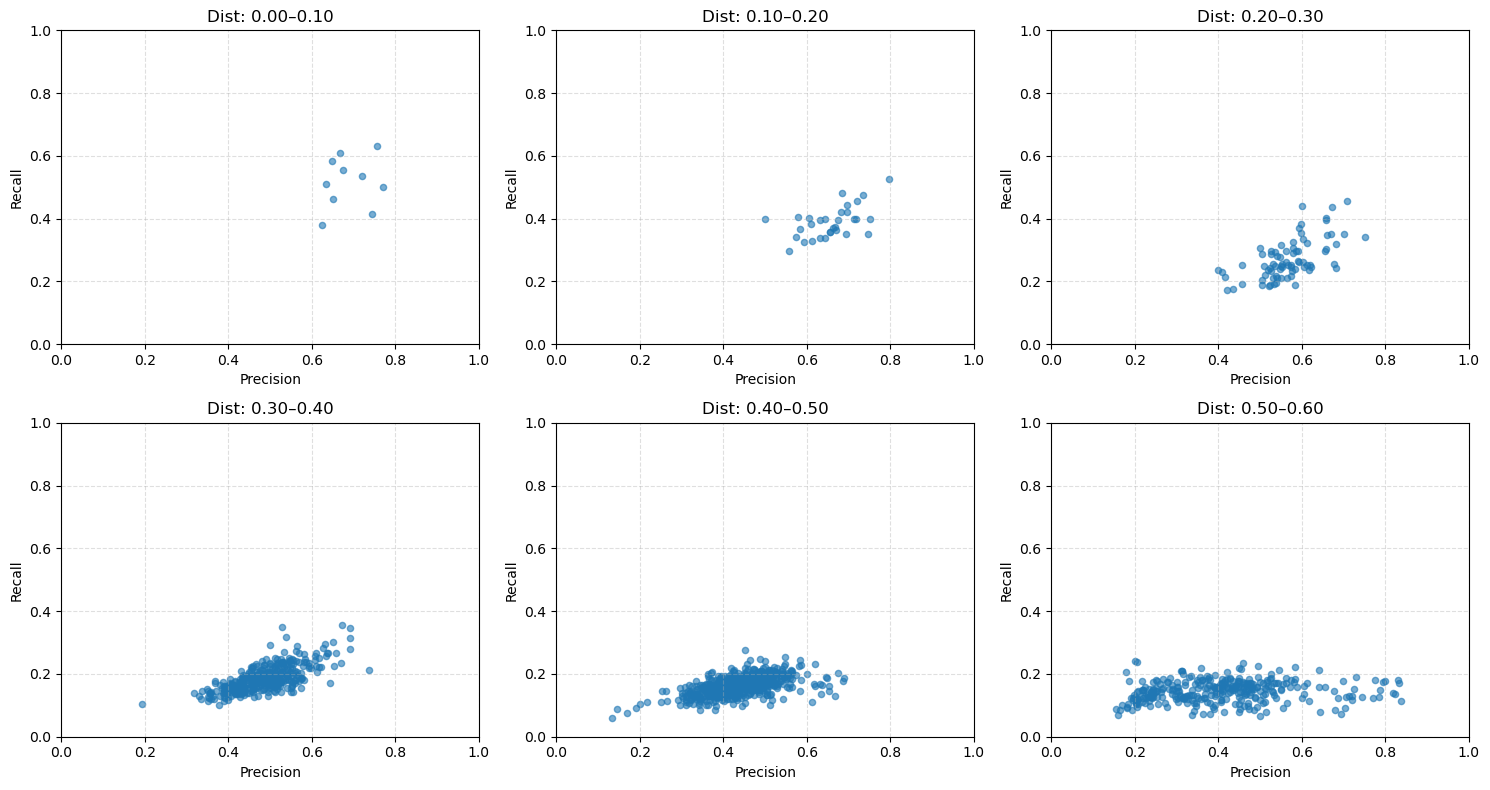

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
dist_min = 0.0
dist_max = 0.6
n_bins = 6   # adjust as needed

# Create bins
bins = np.linspace(dist_min, dist_max, n_bins + 1)

labels = [
    f"{bins[i]:.2f}–{bins[i+1]:.2f}"
    for i in range(len(bins) - 1)
]

merged_df["dist_bin"] = pd.cut(
    merged_df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Get unique bins
bin_categories = merged_df["dist_bin"].cat.categories
n_plots = len(bin_categories)

# Grid size
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Plot
for ax, dist_bin in zip(axes, bin_categories):
    subset = merged_df[merged_df["dist_bin"] == dist_bin]
    
    ax.scatter(
        subset["P"],
        subset["R"],
        alpha=0.6,
        s=20
    )
    
    ax.set_title(f"Dist: {dist_bin}")
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.4)

# Remove unused subplots
for ax in axes[n_plots:]:
    ax.remove()

plt.tight_layout()
plt.show()


In [13]:
top5 = (
    merged_df
    .loc[
        (merged_df["direct_pairwise_dist"] >= 0.0) &
        (merged_df["direct_pairwise_dist"] < 0.2)
    ]
    .sort_values("F1", ascending=False)
    .head(5)
)

print(top5)


            P         R        F1    sample1    sample2    chr  \
297  0.666667  0.610169  0.637168  HG00099.1  HG01891.1  chr12   
247  0.796875  0.525773  0.633540  HG00126.2  HG03654.2  chr12   
188  0.666667  0.584615  0.622951  HG00099.1  HG00133.1  chr12   
662  0.674419  0.555556  0.609244  HG00735.2  NA20809.2  chr12   
440  0.770270  0.500000  0.606383  HG00128.1  HG01784.1  chr12   

     direct_pairwise_dist   dist_bin  
297              0.037073  0.00–0.20  
247              0.147253  0.00–0.20  
188              0.042255  0.00–0.20  
662              0.040491  0.00–0.20  
440              0.075633  0.00–0.20  


In [ ]:
# Quantifying reason for remaining errors 

In [5]:
import pandas as pd
from pathlib import Path

def read_results(path):
    dfs = []

    for file in Path(path).glob("*_BED*_results.txt"):
        # Extract sample1 and sample2 from filename
        # Example: sampleA_sampleB_BED1_results.txt
        parts = file.stem.split("_")
        sample1, sample2 = parts[0], parts[1]

        # Read file
        df = pd.read_csv(file, sep="\t")

        # Add sample columns
        df["sample1"] = sample1
        df["sample2"] = sample2

        dfs.append(df)

    # Combine all files into one DataFrame
    return pd.concat(dfs, ignore_index=True)

# Usage


In [36]:
errors_df = read_results("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/sv_compare/md3k_msf0.5")

In [45]:
df_incorrect = errors_df[errors_df["matched"] == "incorrect"].copy()
df_incorrect.loc[df_incorrect["label"] == "BED1", "label"] = "Centrolign Error"
df_incorrect.loc[df_incorrect["label"] == "BED2", "label"] = "HORHAP Error"

df_incorrect["chr"] = "chr12"

len(df_incorrect)


458257

In [ ]:
# Step 1: define sorted pair function
def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df

# Step 2: create sample_pair columns
df_incorrect_pair = make_sorted_pair(df_incorrect)
all_pairs_dist_pair = make_sorted_pair(all_pairs_dist_df)

# Step 3: merge on sample_pair and chromosome
# Make sure the chromosome column names match; adjust if necessary
merged_df = df_incorrect_pair.merge(
    all_pairs_dist_pair,
    on=["sample_pair", "chr"],  # replace "chr" with your chromosome column name if different
    how="inner"  # can use "left" if you want to keep all incorrect SVs
)

# Step 4: drop temporary sample_pair column
merged_df = merged_df.drop(columns=["sample_pair"])

# Step 5: subset to direct_pairwise_dist < 0.2
merged_df_filtered = merged_df[merged_df["direct_pairwise_dist"] < 0.2]

           #chrom     start       end  size    matched             label  \
20850   HG03654.2  34854686  34858762  4076  incorrect  Centrolign Error   
20851   HG03654.2  34982946  34984305  1359  incorrect  Centrolign Error   
20852   HG03654.2  34988893  34992967  4074  incorrect  Centrolign Error   
20853   HG03654.2  35008218  35009577  1359  incorrect  Centrolign Error   
20854   HG03654.2  35099612  35100971  1359  incorrect  Centrolign Error   
...           ...       ...       ...   ...        ...               ...   
458209  HG00128.1  37557108  37558463  1355  incorrect  Centrolign Error   
458210  HG00128.1  37565002  37570087  5085  incorrect  Centrolign Error   
458211  HG00128.1  37571390  37571730   340  incorrect  Centrolign Error   
458212  HG00128.1  37577059  37578414  1355  incorrect  Centrolign Error   
458213  HG00128.1  37691772  37697205  5433  incorrect  Centrolign Error   

                                                   reason  sample1_x  \
20850          

4364

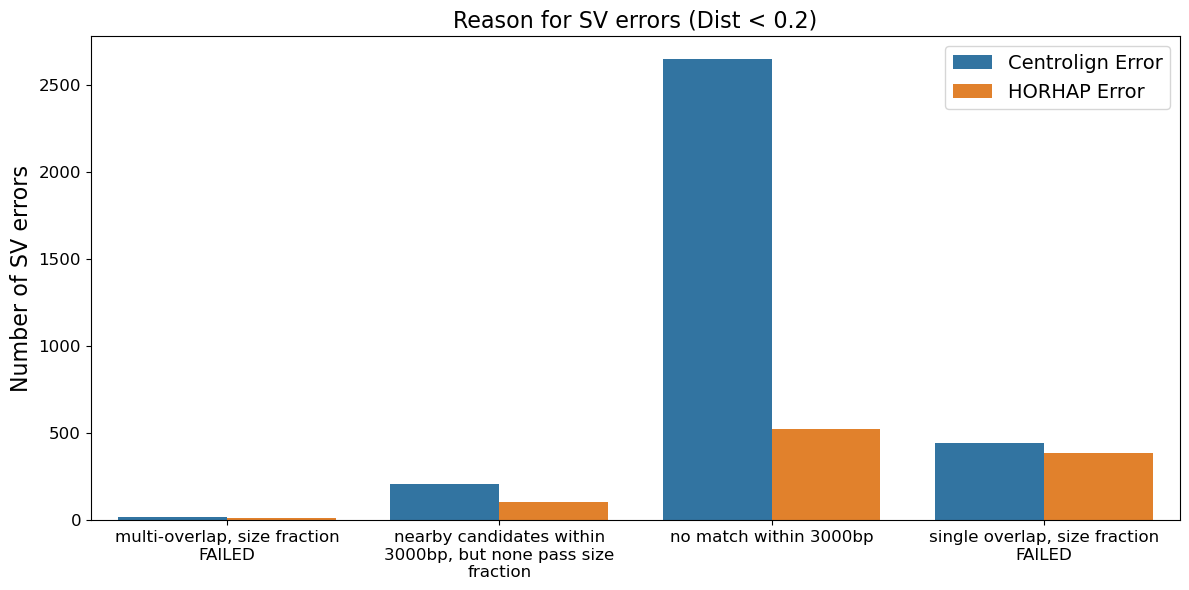

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Example: df_incorrect is your dataframe
counts = merged_df_filtered.groupby(["reason", "label"]).size().reset_index(name="count")

# Wrap long reason labels at ~30 characters
counts["reason_wrapped"] = counts["reason"].apply(lambda x: "\n".join(textwrap.wrap(x, width=30)))

plt.figure(figsize=(12,6))
sns.barplot(data=counts, x="reason_wrapped", y="count", hue="label", palette=["#1f77b4","#ff7f0e"])

plt.ylabel("Number of SV errors",fontsize=16)
plt.title("Reason for SV errors (Dist < 0.2)",fontsize=16)
plt.xticks(rotation=0, fontsize=12)  # keep labels horizontal now that they are wrapped
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.xlabel("")
plt.tight_layout()
plt.show()



### ChrX

In [4]:
## get list of horhap and centrolign beds matched by sample pair

path1="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chrX/SV_beds/chrX"
path2="/private/groups/migalab/fryabov/HPRC/horhap_alignments/chrX/CV_bed"

output_csv = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/matched_beds.csv"
match_beds(path1, path2, output_csv)

In [18]:
directory = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/sv_compare/md3k_msf0.5/"
df = load_summary_files(directory)
df["chr"]="chrX"

def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df
df = make_sorted_pair(df)
all_pairs_dist_df = make_sorted_pair(all_pairs_dist_df)

merged_df = df.merge(
    all_pairs_dist_df,
    on=["sample_pair", "chr"],
    how="inner"   # or "left" depending on your intent
)

merged_df = merged_df.drop(columns=["sample_pair","sample1_x","sample2_x"])
merged_df.rename(columns={
    "sample1_y": "sample1",
    "sample2_y": "sample2"
}, inplace=True)


print(merged_df)

             P         R        F1   chr    sample1    sample2  \
0     0.629032  0.224865  0.331298  chrX  HG01981.2  NA18747.2   
1     0.588000  0.248984  0.349833  chrX  HG00544.2  NA19776.1   
2     0.379679  0.171159  0.235951  chrX  HG01786.1  NA21106.2   
3     0.000000  0.000000  0.000000  chrX    HG002.2  HG01969.2   
4     0.636364  0.380952  0.476596  chrX  HG01943.2  HG01978.2   
...        ...       ...       ...   ...        ...        ...   
6985  0.557971  0.274864  0.368299  chrX  HG01150.1  NA18976.2   
6986  0.267925  0.176950  0.213135  chrX  HG03927.2  NA18976.2   
6987  0.268817  0.089130  0.133873  chrX  HG00673.2  HG01784.1   
6988  0.573643  0.252907  0.351046  chrX  NA18959.2  NA19909.1   
6989  0.685185  0.178938  0.283768  chrX  HG00639.2  NA18970.2   

      direct_pairwise_dist  
0                 0.337801  
1                 0.332230  
2                 0.328900  
3                 0.289408  
4                 0.102457  
...                    ...  
6985

In [20]:
# Drop HG002 which failed due to assembly discrepancy
df_filtered = merged_df[
    (merged_df["sample1"] != "HG002.2") & (merged_df["sample2"] != "HG002.2")
]
print(df_filtered)

             P         R        F1   chr    sample1    sample2  \
0     0.629032  0.224865  0.331298  chrX  HG01981.2  NA18747.2   
1     0.588000  0.248984  0.349833  chrX  HG00544.2  NA19776.1   
2     0.379679  0.171159  0.235951  chrX  HG01786.1  NA21106.2   
4     0.636364  0.380952  0.476596  chrX  HG01943.2  HG01978.2   
5     0.724576  0.174870  0.281744  chrX  HG03784.2  NA20503.2   
...        ...       ...       ...   ...        ...        ...   
6985  0.557971  0.274864  0.368299  chrX  HG01150.1  NA18976.2   
6986  0.267925  0.176950  0.213135  chrX  HG03927.2  NA18976.2   
6987  0.268817  0.089130  0.133873  chrX  HG00673.2  HG01784.1   
6988  0.573643  0.252907  0.351046  chrX  NA18959.2  NA19909.1   
6989  0.685185  0.178938  0.283768  chrX  HG00639.2  NA18970.2   

      direct_pairwise_dist  
0                 0.337801  
1                 0.332230  
2                 0.328900  
4                 0.102457  
5                 0.368893  
...                    ...  
6985

/data/tmp/ipykernel_4007515/1291248052.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["dist_bin"] = pd.cut(
/data/tmp/ipykernel_4007515/1291248052.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/data/tmp/ipykernel_4007515/1291248052.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


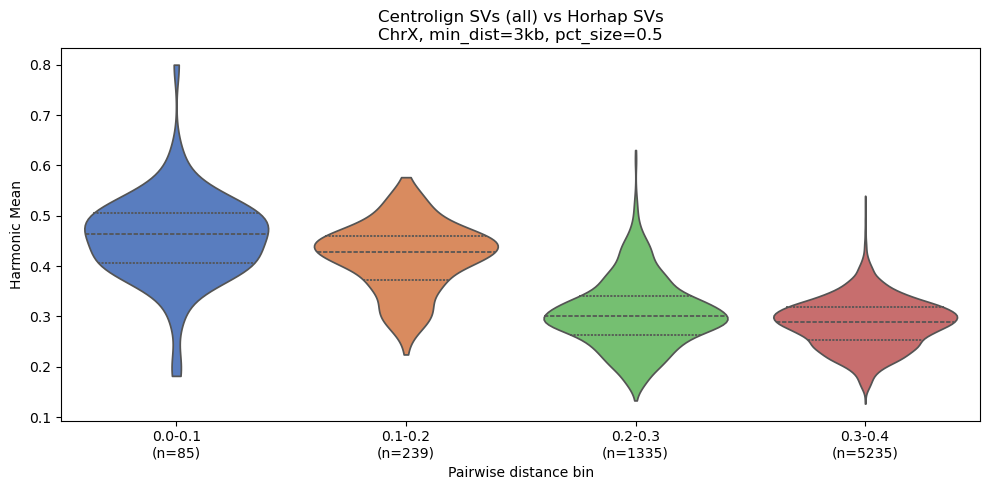

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Create bins for pairwise distance (0–0.7)
bins = np.arange(0, 0.5, 0.1)  # 0.0, 0.1, ..., 0.7
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

df_filtered["dist_bin"] = pd.cut(
    df_filtered["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 2️⃣ Count number of rows per bin (preserve bin order)
bin_counts = (
    df_filtered["dist_bin"]
    .value_counts()
    .reindex(labels, fill_value=0)
)

# 3️⃣ Plot violin plot
plt.figure(figsize=(10,5))
ax = sns.violinplot(
    data=df_filtered,
    x="dist_bin",
    y="F1",
    inner="quartile",   # median + quartiles
    cut=0,              # limit tails to data range
    palette="muted"
)

# 4️⃣ Replace x-axis labels with bin + count
xtick_labels = [
    f"{label}\n(n={bin_counts[label]})"
    for label in labels
]
ax.set_xticklabels(xtick_labels)

# 5️⃣ Labels and formatting
ax.set_xlabel("Pairwise distance bin")
ax.set_ylabel("Harmonic Mean")
ax.set_title(
    "Centrolign SVs (all) vs Horhap SVs\n"
    "ChrX, min_dist=3kb, pct_size=0.5"
)

plt.tight_layout()
plt.show()



/data/tmp/ipykernel_4007515/3234130921.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["dist_bin"] = pd.cut(


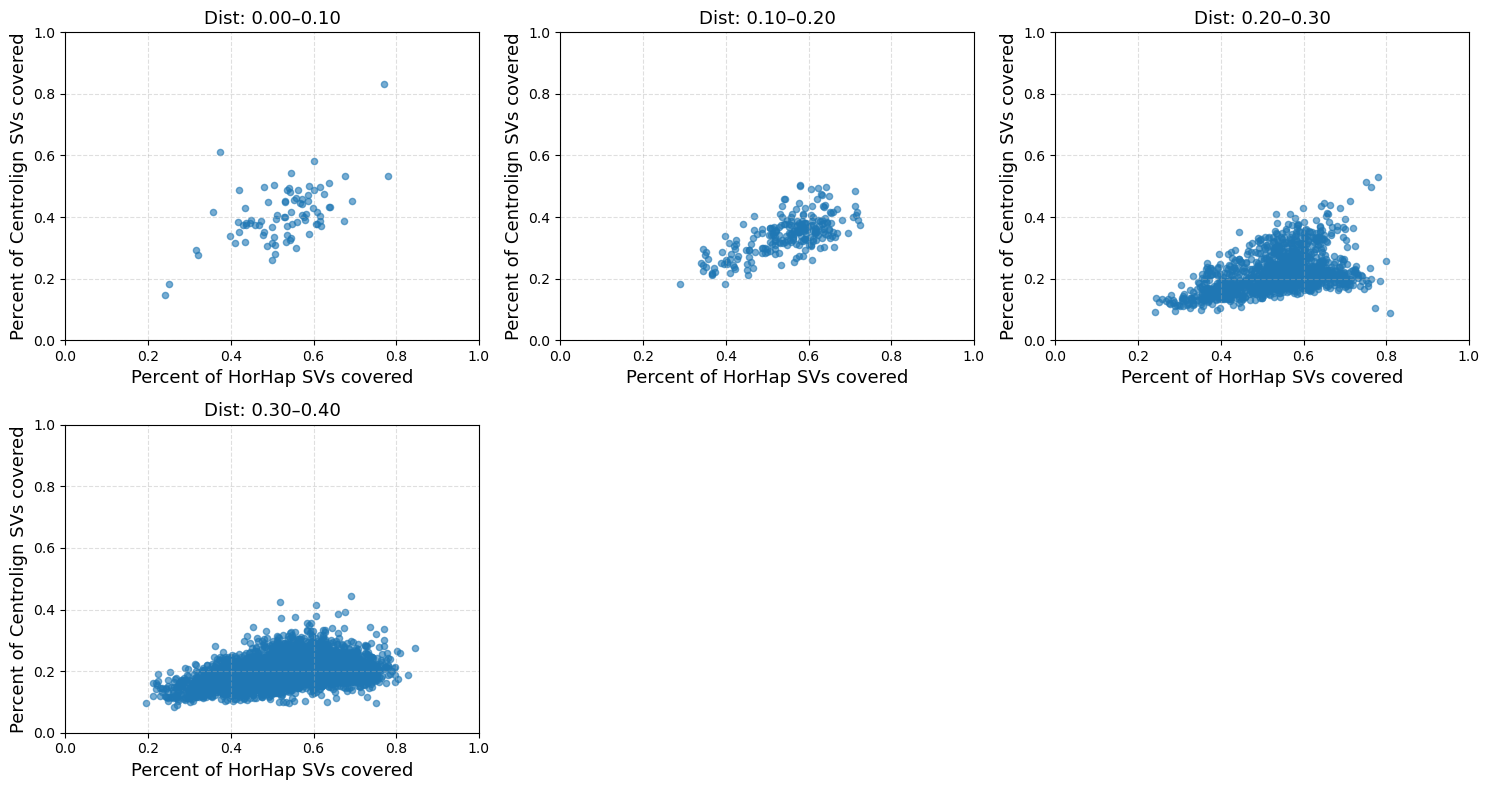

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
dist_min = 0.0
dist_max = 0.4
n_bins = 4   # adjust as needed

# Create bins
bins = np.linspace(dist_min, dist_max, n_bins + 1)

labels = [
    f"{bins[i]:.2f}–{bins[i+1]:.2f}"
    for i in range(len(bins) - 1)
]

df_filtered["dist_bin"] = pd.cut(
    df_filtered["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Get unique bins
bin_categories = df_filtered["dist_bin"].cat.categories
n_plots = len(bin_categories)

# Grid size
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Plot
for ax, dist_bin in zip(axes, bin_categories):
    subset = df_filtered[df_filtered["dist_bin"] == dist_bin]
    
    ax.scatter(
        subset["P"],
        subset["R"],
        alpha=0.6,
        s=20
    )
    
    ax.set_title(f"Dist: {dist_bin}",fontsize=13)
    ax.set_xlabel("Percent of HorHap SVs covered",fontsize=13)
    ax.set_ylabel("Percent of Centrolign SVs covered",fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.4)

# Remove unused subplots
for ax in axes[n_plots:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [27]:
errors_df = read_results("/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/sv_compare/md3k_msf0.5/")

In [28]:
df_incorrect = errors_df[errors_df["matched"] == "incorrect"].copy()
df_incorrect.loc[df_incorrect["label"] == "BED1", "label"] = "Centrolign Error"
df_incorrect.loc[df_incorrect["label"] == "BED2", "label"] = "HORHAP Error"

df_incorrect["chr"] = "chrX"

len(df_incorrect)

5370638

In [29]:
# Step 1: define sorted pair function
def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df

# Step 2: create sample_pair columns
df_incorrect_pair = make_sorted_pair(df_incorrect)
all_pairs_dist_pair = make_sorted_pair(all_pairs_dist_df)

# Step 3: merge on sample_pair and chromosome
# Make sure the chromosome column names match; adjust if necessary
merged_df = df_incorrect_pair.merge(
    all_pairs_dist_pair,
    on=["sample_pair", "chr"],  # replace "chr" with your chromosome column name if different
    how="inner"  # can use "left" if you want to keep all incorrect SVs
)

# Step 4: drop temporary sample_pair column
merged_df = merged_df.drop(columns=["sample_pair"])

# Step 5: subset to direct_pairwise_dist < 0.2
df_filtered = merged_df[merged_df["direct_pairwise_dist"] < 0.2]

In [30]:
df_filtered.head()

,#chrom,start,end,size,matched,label,reason,sample1_x,sample2_x,chr,sample1_y,sample2_y,direct_pairwise_dist
8409,HG02148#1#CM087994.1,57915673,57925957,10284,incorrect,HORHAP Error,"nearby candidates within 3000bp, but none pass...",HG01978.2,HG02148.1,chrX,HG01978.2,HG02148.1,0.142834
8410,HG02148#1#CM087994.1,57950640,57952697,2057,incorrect,HORHAP Error,no match within 3000bp,HG01978.2,HG02148.1,chrX,HG01978.2,HG02148.1,0.142834
8411,HG02148#1#CM087994.1,58080225,58088112,7887,incorrect,HORHAP Error,no match within 3000bp,HG01978.2,HG02148.1,chrX,HG01978.2,HG02148.1,0.142834
8412,HG02148#1#CM087994.1,58104562,58108673,4111,incorrect,HORHAP Error,no match within 3000bp,HG01978.2,HG02148.1,chrX,HG01978.2,HG02148.1,0.142834
8413,HG02148#1#CM087994.1,58253853,58255909,2056,incorrect,HORHAP Error,no match within 3000bp,HG01978.2,HG02148.1,chrX,HG01978.2,HG02148.1,0.142834


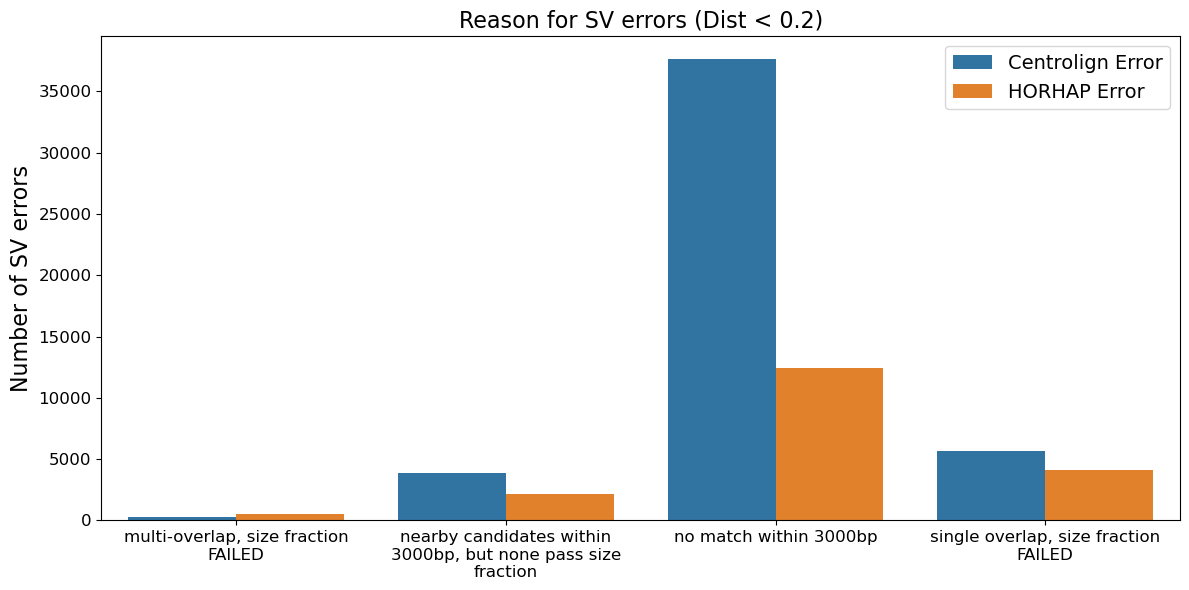

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Example: df_incorrect is your dataframe
counts = df_filtered.groupby(["reason", "label"]).size().reset_index(name="count")

# Wrap long reason labels at ~30 characters
counts["reason_wrapped"] = counts["reason"].apply(lambda x: "\n".join(textwrap.wrap(x, width=30)))

plt.figure(figsize=(12,6))
sns.barplot(data=counts, x="reason_wrapped", y="count", hue="label", palette=["#1f77b4","#ff7f0e"])

plt.ylabel("Number of SV errors",fontsize=16)
plt.title("Reason for SV errors (Dist < 0.2)",fontsize=16)
plt.xticks(rotation=0, fontsize=12)  # keep labels horizontal now that they are wrapped
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.xlabel("")
plt.tight_layout()
plt.show()

In [ ]:
# get list of sample pairs missing in Fedor's BED folder 
import pandas as pd
from pathlib import Path

# --- 1. Read CSV and create sorted sample pairs ---
csv_file = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices_lt0.4/chrX_r2_QC_v2_centrolign_pairwise_distance.csv"

# No header, so specify column names
df_csv = pd.read_csv(csv_file, header=None, names=["sample1", "sample2", "dist"])

# Create a new column with sorted sample pair
df_csv["sample_pair"] = df_csv.apply(
    lambda row: "_".join(sorted([row["sample1"], row["sample2"]])),
    axis=1
)

# Keep only the sample_pair column
df_csv_pairs = df_csv[["sample_pair"]]

# --- 2. Read BED files in a folder and extract sample pairs ---
bed_path = Path("/private/groups/migalab/fryabov/HPRC/horhap_alignments/chrX/CV_bed")
bed_files = list(bed_path.glob("*.bed"))

bed_pairs = []

for bf in bed_files:
    # filename is like "sample1_sample2.bed"
    name = bf.stem  # removes ".bed"
    samples = name.split("_")
    if len(samples) != 2:
        raise ValueError(f"Unexpected BED filename format: {bf.name}")
    bed_pairs.append("_".join(sorted(samples)))

# Convert to DataFrame
df_bed_pairs = pd.DataFrame({"sample_pair": bed_pairs})

# --- 3. Find sample pairs in CSV missing from BED files ---
missing_pairs = df_csv_pairs.loc[
    ~df_csv_pairs["sample_pair"].isin(df_bed_pairs["sample_pair"])
]

print("Missing sample pairs:")
print(missing_pairs)

missing_chm13 = missing_pairs[
    missing_pairs["sample_pair"].str.contains("CHM13.0")
]

print(missing_chm13)


Missing sample pairs:
            sample_pair
16    CHM13.0_NA20282.1
124   CHM13.0_NA19909.1
285   CHM13.0_HG01969.1
312   CHM13.0_HG00140.2
325   CHM13.0_HG02132.2
...                 ...
6829  CHM13.0_HG03041.1
6865  CHM13.0_HG00128.1
6873  CHM13.0_HG00741.1
6878  CHM13.0_HG02293.2
7032  CHM13.0_HG01943.2

[86 rows x 1 columns]
            sample_pair
16    CHM13.0_NA20282.1
124   CHM13.0_NA19909.1
285   CHM13.0_HG01969.1
312   CHM13.0_HG00140.2
325   CHM13.0_HG02132.2
...                 ...
6829  CHM13.0_HG03041.1
6865  CHM13.0_HG00128.1
6873  CHM13.0_HG00741.1
6878  CHM13.0_HG02293.2
7032  CHM13.0_HG01943.2

[85 rows x 1 columns]


### Chr X and Chr 12, SV COMPARE V2

In [6]:
directory1 = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chr12/sv_compare2/md3k_msf0.5/"
df1 = load_summary_files(directory1)
df1["chr"]="chr12"

directory2 = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/sv_compare2/md4.5k_msf0.5/"
df2 = load_summary_files(directory2)
df2["chr"]="chrX"
# remove HG002 from chrX, failed due to assembly discrepancy
df2 = df2[(df2["sample1"] != "HG002.2") & (df2["sample2"] != "HG002.2")]

df_all = pd.concat([df1, df2], ignore_index=True)
df_all.head()

,P,R,F1,sample1,sample2,chr
0,0.467290,0.215539,0.295005,HG03688.1,NA19835.1,chr12
1,0.408163,0.181579,0.251343,HG02280.2,HG01192.1,chr12
2,0.523810,0.183024,0.271265,HG01258.2,HG01109.1,chr12
3,0.516129,0.203518,0.291925,HG01940.1,HG02698.1,chr12
4,0.132653,0.075117,0.095919,HG01993.2,HG02559.2,chr12


In [67]:
# Merge DF with all pairs
def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df

df = make_sorted_pair(df_all)
all_pairs_dist_df = make_sorted_pair(all_pairs_dist_df)

merged_df = df.merge(
    all_pairs_dist_df,
    on=["sample_pair", "chr"],
    how="inner"   # or "left" depending on your intent
)

merged_df = merged_df.drop(columns=["sample_pair","sample1_x","sample2_x"])
merged_df.rename(columns={
    "sample1_y": "sample1",
    "sample2_y": "sample2"
}, inplace=True)


print(merged_df)

             P         R        F1    chr    sample1    sample2  \
0     0.467290  0.215539  0.295005  chr12  HG03688.1  NA19835.1   
1     0.408163  0.181579  0.251343  chr12  HG01192.1  HG02280.2   
2     0.523810  0.183024  0.271265  chr12  HG01109.1  HG01258.2   
3     0.516129  0.203518  0.291925  chr12  HG01940.1  HG02698.1   
4     0.132653  0.075117  0.095919  chr12  HG01993.2  HG02559.2   
...        ...       ...       ...    ...        ...        ...   
8374  0.648551  0.365280  0.467342   chrX  HG01150.1  NA18976.2   
8375  0.320755  0.236321  0.272139   chrX  HG03927.2  NA18976.2   
8376  0.370968  0.160870  0.224420   chrX  HG00673.2  HG01784.1   
8377  0.751938  0.322674  0.451570   chrX  NA18959.2  NA19909.1   
8378  0.782407  0.249767  0.378656   chrX  HG00639.2  NA18970.2   

      direct_pairwise_dist  
0                 0.439047  
1                 0.485396  
2                 0.380223  
3                 0.391702  
4                 0.487003  
...                  

/data/tmp/ipykernel_192648/4057354341.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["dist_bin", "chr"])
/data/tmp/ipykernel_192648/4057354341.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


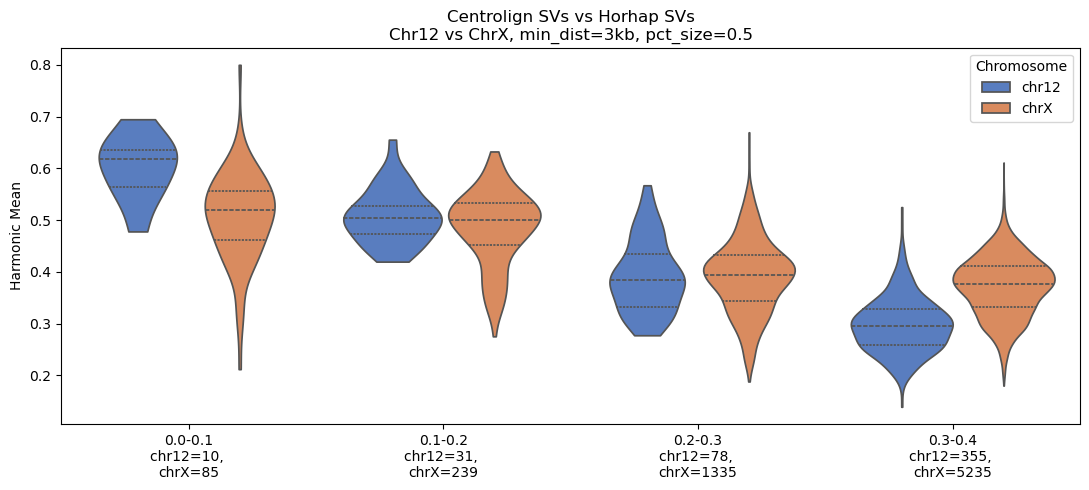

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Create bins for pairwise distance (0–0.7)
bins = np.arange(0, 0.5, 0.1)
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

merged_df["dist_bin"] = pd.cut(
    merged_df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 2️⃣ Restrict to chr12 and chrX
plot_df = merged_df[merged_df["chr"].isin(["chr12", "chrX"])]

# 3️⃣ Count number of rows per bin (all chromosomes combined)
# Count rows per bin *per chromosome*
bin_counts_chr = (
    plot_df
    .groupby(["dist_bin", "chr"])
    .size()
    .unstack(fill_value=0)
    .reindex(labels)
)


# 4️⃣ Plot violin plot with separate violins per chromosome
plt.figure(figsize=(11, 5))
ax = sns.violinplot(
    data=plot_df,
    x="dist_bin",
    y="F1",
    hue="chr",
    dodge=True,          # separate violins per bin
    inner="quartile",
    cut=0,
    palette="muted"
)

# 5️⃣ Replace x-axis labels with bin + count
xtick_labels = [
    f"{label}\nchr12={bin_counts_chr.loc[label, 'chr12']}, "
    f"\nchrX={bin_counts_chr.loc[label, 'chrX']}"
    for label in labels
]

ax.set_xticklabels(xtick_labels)

# 6️⃣ Labels and formatting
ax.set_xlabel("")
ax.set_ylabel("Harmonic Mean")
ax.set_title(
    "Centrolign SVs vs Horhap SVs\n"
    "Chr12 vs ChrX, min_dist=3kb, pct_size=0.5"
)

ax.legend(title="Chromosome")
plt.tight_layout()
plt.show()


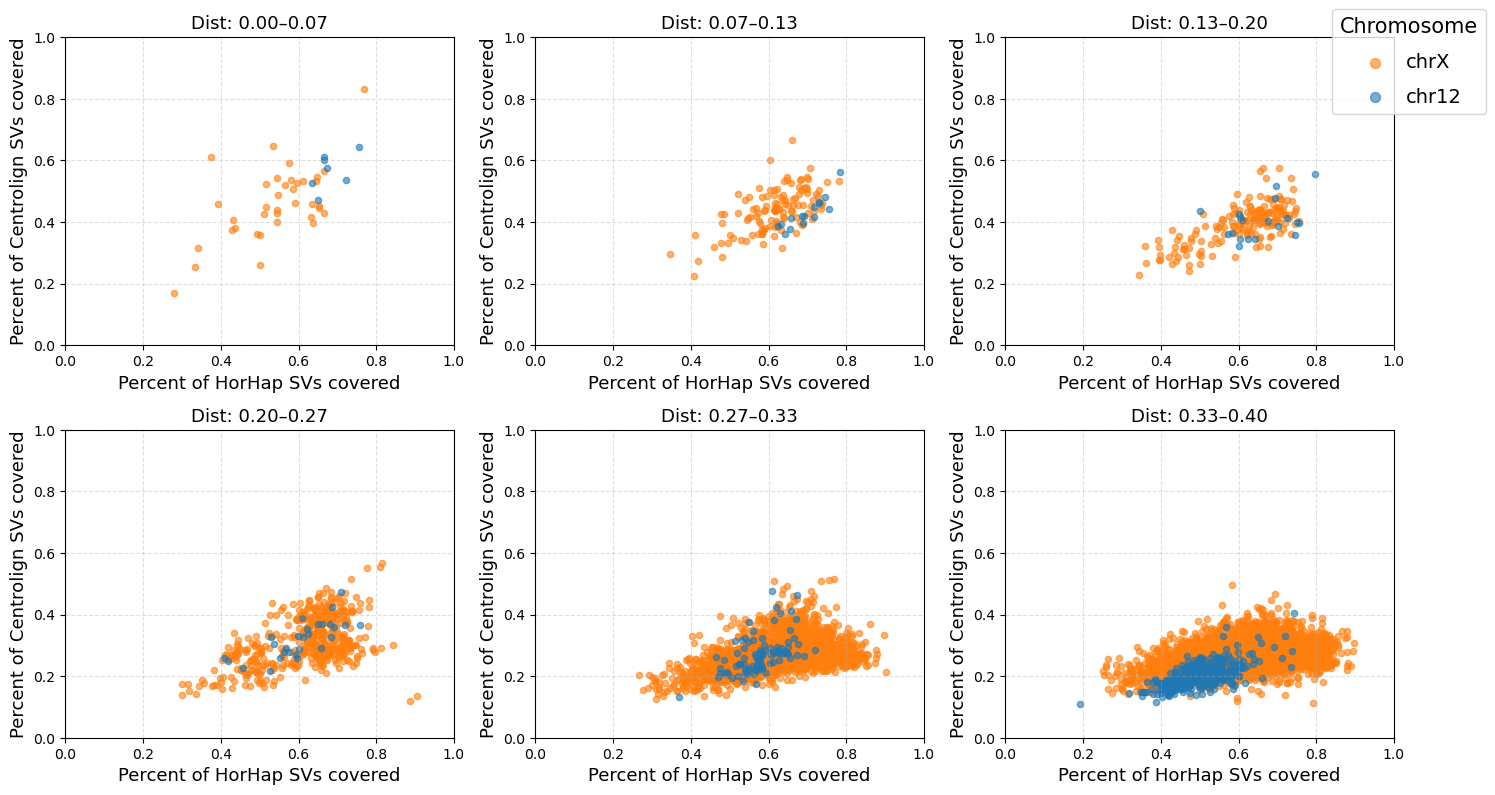

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
dist_min = 0.0
dist_max = 0.4
n_bins = 6

# Create bins
bins = np.linspace(dist_min, dist_max, n_bins + 1)
labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

merged_df["dist_bin"] = pd.cut(
    merged_df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

chr_order = ["chrX", "chr12"]

# Chromosomes to plot and colors
chr_colors = {
    "chr12": "tab:blue",
    "chrX": "tab:orange"
}

# Get unique bins
bin_categories = merged_df["dist_bin"].cat.categories
n_plots = len(bin_categories)

# Grid size
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Plot
for ax, dist_bin in zip(axes, bin_categories):
    subset = merged_df[merged_df["dist_bin"] == dist_bin]

    for chr_name in chr_order:
        chr_subset = subset[subset["chr"] == chr_name]

        ax.scatter(
            chr_subset["P"],
            chr_subset["R"],
            s=20,
            alpha=0.6,
            color=chr_colors[chr_name],
            label=chr_name
        )

    ax.set_title(f"Dist: {dist_bin}", fontsize=13)
    ax.set_xlabel("Percent of HorHap SVs covered", fontsize=13)
    ax.set_ylabel("Percent of Centrolign SVs covered", fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.4)

# Remove unused subplots
for ax in axes[n_plots:]:
    ax.remove()

# Add a single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Chromosome",
    loc="upper right",
    fontsize=14,          # label text size
    title_fontsize=15,    # title size
    markerscale=1.6,      # marker size in legend
    labelspacing=0.8,     # vertical spacing
    handletextpad=0.6
)


plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


In [29]:
errors_df = read_results("/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chr12/sv_compare2/md3k_msf0.5/")
errors_df2 = read_results("/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/sv_compare2/md4.5k_msf0.5/")

In [30]:
errors_df["chr"]="chr12"
errors_df2["chr"]="chrX"
errors_df_all = pd.concat([errors_df, errors_df2], ignore_index=True)

In [42]:
df_incorrect = errors_df_all.copy()
df_incorrect.loc[df_incorrect["label"] == "BED1", "label"] = "Centrolign Only"
df_incorrect.loc[df_incorrect["label"] == "BED2", "label"] = "HORHAP Only"
df_incorrect.loc[df_incorrect["reason"] == "best subset size fraction failed min_size_frac", "reason"] = "SVs in window failed size threshold"
df_incorrect.loc[df_incorrect["reason"] == "no SVs overlap expanded window", "reason"] = "No SVs in expanded window"

len(df_incorrect)

7814682

In [43]:
# Step 1: define sorted pair function
def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df

# Step 2: create sample_pair columns
df_incorrect_pair = make_sorted_pair(df_incorrect)
all_pairs_dist_pair = make_sorted_pair(all_pairs_dist_df)

# Step 3: merge on sample_pair and chromosome
# Make sure the chromosome column names match; adjust if necessary
merged_df = df_incorrect_pair.merge(
    all_pairs_dist_pair,
    on=["sample_pair", "chr"],  # replace "chr" with your chromosome column name if different
    how="inner"  # can use "left" if you want to keep all incorrect SVs
)

# Step 4: drop temporary sample_pair column
merged_df = merged_df.drop(columns=["sample_pair"])

# Step 5: subset to direct_pairwise_dist < 0.2
df_filtered = merged_df[merged_df["direct_pairwise_dist"] < 0.2]

In [44]:
merged_df[merged_df["matched"]=="correct"]

,#chrom,start,end,size,matched,label,reason,sample1_x,sample2_x,chr,sample1_y,sample2_y,direct_pairwise_dist
10,NA21106.1,34987598,34988957,1359,correct,Centrolign Only,windowed-contiguous match,HG00099.1,NA21106.1,chr12,HG00099.1,NA21106.1,0.384634
47,NA21106.1,36014098,36015453,1355,correct,Centrolign Only,windowed-contiguous match,HG00099.1,NA21106.1,chr12,HG00099.1,NA21106.1,0.384634
61,NA21106.1,36323770,36327848,4078,correct,Centrolign Only,windowed-contiguous match,HG00099.1,NA21106.1,chr12,HG00099.1,NA21106.1,0.384634
71,NA21106.1,36443296,36444655,1359,correct,Centrolign Only,windowed-contiguous match,HG00099.1,NA21106.1,chr12,HG00099.1,NA21106.1,0.384634
72,NA21106.1,36456663,36465308,8645,correct,Centrolign Only,windowed-contiguous match,HG00099.1,NA21106.1,chr12,HG00099.1,NA21106.1,0.384634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814672,HG01496#2#CM086401.1,60463286,60469453,6167,correct,HORHAP Only,windowed-contiguous match,HG02148.1,HG01496.2,chrX,HG01496.2,HG02148.1,0.140336
7814673,HG01496#2#CM086401.1,60492076,60502360,10284,correct,HORHAP Only,windowed-contiguous match,HG02148.1,HG01496.2,chrX,HG01496.2,HG02148.1,0.140336
7814675,HG01496#2#CM086401.1,60570231,60572288,2057,correct,HORHAP Only,windowed-contiguous match,HG02148.1,HG01496.2,chrX,HG01496.2,HG02148.1,0.140336
7814677,HG01496#2#CM086401.1,60661748,60664656,2908,correct,HORHAP Only,windowed-contiguous match,HG02148.1,HG01496.2,chrX,HG01496.2,HG02148.1,0.140336


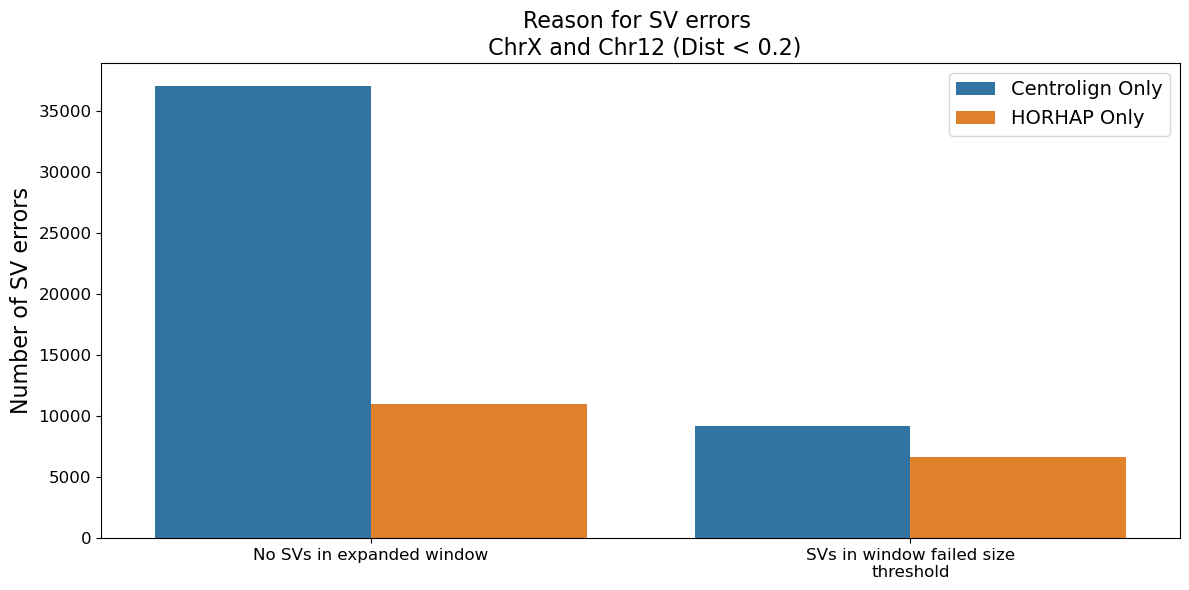

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Example: df_incorrect is your dataframe
counts = df_filtered.groupby(["reason", "label"]).size().reset_index(name="count")

# Wrap long reason labels at ~30 characters
counts["reason_wrapped"] = counts["reason"].apply(lambda x: "\n".join(textwrap.wrap(x, width=30)))

plt.figure(figsize=(12,6))
sns.barplot(data=counts, x="reason_wrapped", y="count", hue="label", palette=["#1f77b4","#ff7f0e"])

plt.ylabel("Number of SV errors",fontsize=16)
plt.title("Reason for SV errors \n ChrX and Chr12 (Dist < 0.2)",fontsize=16)
plt.xticks(rotation=0, fontsize=12)  # keep labels horizontal now that they are wrapped
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.xlabel("")
plt.tight_layout()
plt.show()

In [65]:
worst_chrX = (
    merged_df[
        (merged_df["chr"] == "chrX") &
        (merged_df["direct_pairwise_dist"] < 0.07)
    ]
    .sort_values("F1", ascending=True)
)

worst_chrX


,P,R,F1,chr,sample1,sample2,direct_pairwise_dist
2247,0.240000,0.146341,0.181818,chrX,NA18505.2,NA19700.2,0.022682
6103,0.277778,0.218182,0.244399,chrX,HG03579.2,NA18505.2,0.054650
2965,0.315789,0.292135,0.303502,chrX,HG03209.2,HG03516.1,0.064117
5845,0.500000,0.261905,0.343750,chrX,HG03516.2,NA18505.2,0.024439
2193,0.357143,0.416667,0.384615,chrX,HG02583.1,HG02630.2,0.024896
4964,0.440000,0.366667,0.400000,chrX,HG02965.2,HG03139.2,0.036225
7796,0.428571,0.375000,0.400000,chrX,HG00642.2,HG01175.2,0.008498
4743,0.477273,0.349206,0.403317,chrX,HG00146.1,HG00329.2,0.051206
2386,0.417722,0.395349,0.406227,chrX,HG03669.1,NA20762.2,0.043916
7963,0.437500,0.380952,0.407273,chrX,HG03516.2,NA19700.2,0.020198


### Stratify performance by size 

In [45]:
df_filtered['matched'].value_counts(dropna=False)


matched
incorrect    63902
correct      56258
Name: count, dtype: int64

In [50]:
pair_props[pair_props['prop_correct'].isna()].head()


,chr,size_bin,label,sample_pair,prop_correct
0,chr12,<100 bp,Centrolign Only,HG00097.1_HG00099.1,NaN
1,chr12,<100 bp,Centrolign Only,HG00097.1_HG02300.2,NaN
2,chr12,<100 bp,Centrolign Only,HG00097.2_HG00253.1,NaN
3,chr12,<100 bp,Centrolign Only,HG00097.2_HG01150.2,NaN
4,chr12,<100 bp,Centrolign Only,HG00097.2_HG03669.1,NaN


In [49]:
df_filtered['matched'].value_counts(dropna=False)


matched
incorrect    63902
correct      56258
Name: count, dtype: int64

/data/tmp/ipykernel_1254148/359759965.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sample_pair'] = df_filtered.apply(
/data/tmp/ipykernel_1254148/359759965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['size_bin'] = pd.cut(df_filtered['size'], bins=bins, labels=labels)
/data/tmp/ipykernel_1254148/359759965.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current b

                    size_bin  n_points
0         SV size: 50-100 bp       177
1      SV size: 100-1,000 bp       172
2    SV size: 1,000-5,000 bp       371
3   SV size: 5,000-10,000 bp       368
4  SV size: 10,000-50,000 bp       369
5        SV size: 50,000+ bp       236


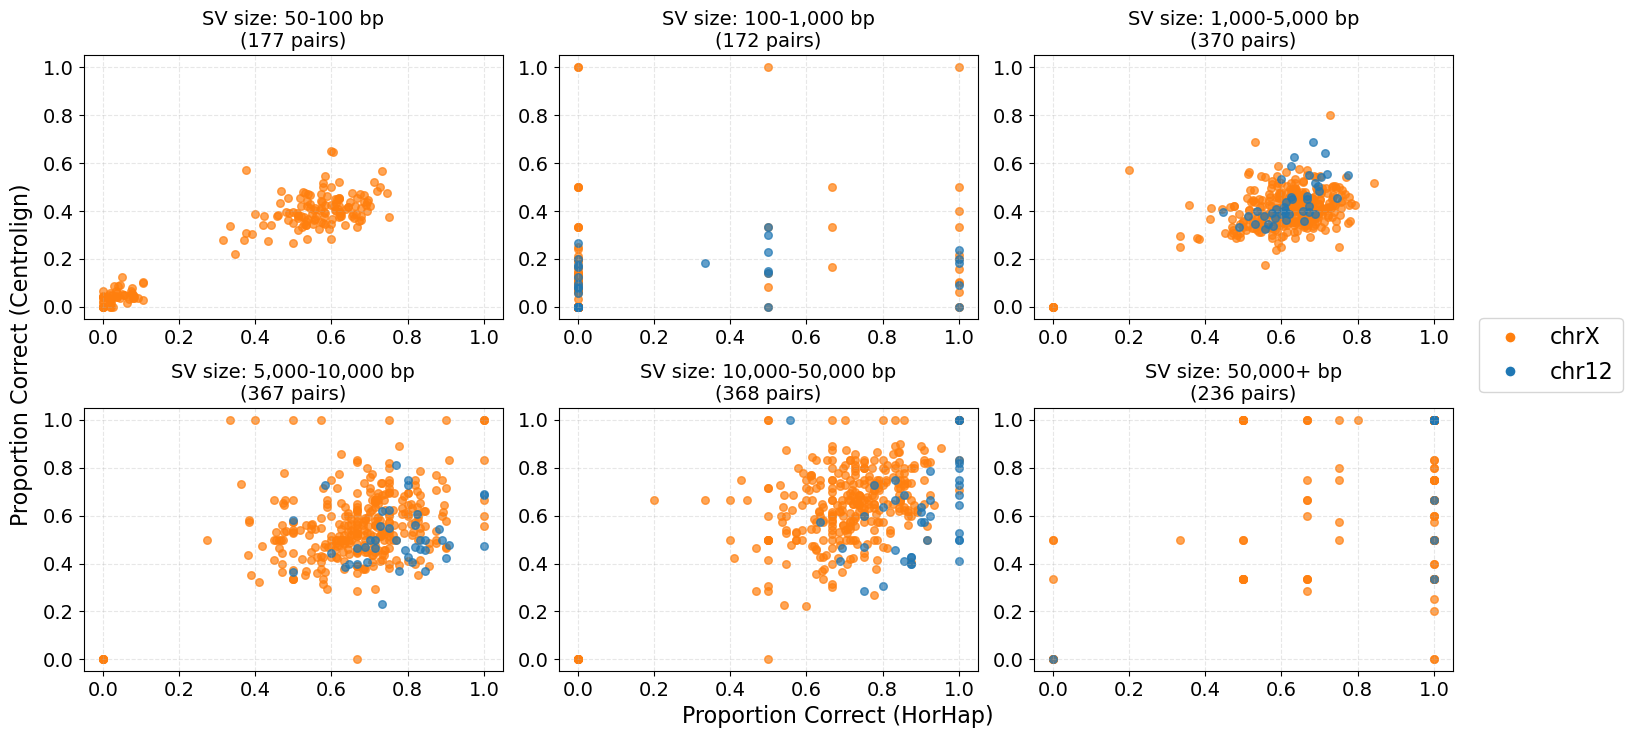

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Define bins and labels
bins = [-float('inf'), 100, 1000, 5000, 10000, 50000, float('inf')]
labels = ['SV size: 50-100 bp', 'SV size: 100-1,000 bp', 'SV size: 1,000-5,000 bp', 'SV size: 5,000-10,000 bp',
          'SV size: 10,000-50,000 bp', 'SV size: 50,000+ bp']

# Sample pair column
df_filtered['sample_pair'] = df_filtered.apply(
    lambda r: '_'.join(sorted([str(r['sample1_x']), str(r['sample2_x'])])),
    axis=1
)

# Size bin
df_filtered['size_bin'] = pd.cut(df_filtered['size'], bins=bins, labels=labels)

# Compute proportion correct per sample pair
pair_props = (
    df_filtered
    .groupby(['chr', 'size_bin', 'label', 'sample_pair'], observed=True)
    .agg(
        n_total=('matched', 'size'),
        n_correct=('matched', lambda x: (x == 'correct').sum())
    )
    .reset_index()
)

pair_props['prop_correct'] = pair_props['n_correct'] / pair_props['n_total']

# Separate Centrolign and HorHap
centro = pair_props[pair_props['label'] == 'Centrolign Only'].rename(columns={'prop_correct': 'prop_correct_centrolign'})
horhap = pair_props[pair_props['label'] == 'HORHAP Only'].rename(columns={'prop_correct': 'prop_correct_horhap'})

summary = pd.merge(
    centro,
    horhap,
    on=['chr', 'size_bin', 'sample_pair'],
    how='inner'
)

# Count points per size bin
counts_per_bin = summary.groupby('size_bin').size().reset_index(name='n_points')

print(counts_per_bin)


# --- MANUALLY CONTROL CHR ORDER ---
chr_order = ['chrX', 'chr12']  # chr12 second
chrom_colors = {
    'chrX': 'tab:orange',
    'chr12': 'tab:blue'
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for ax, bin_label in zip(axes, labels):
    sub = summary[summary['size_bin'] == bin_label]

    # Count number of sample pairs plotted in this bin
    n_pairs = sub['sample_pair'].nunique()

    # Loop over chromosomes in explicit order
    for chrom in chr_order:
        chrom_df = sub[sub['chr'] == chrom]
        ax.scatter(
            chrom_df['prop_correct_horhap'],
            chrom_df['prop_correct_centrolign'],
            color=chrom_colors[chrom],
            label=chrom,
            alpha=0.7,
            s=30
        )
    
    ax.set_title(f"{bin_label}\n({n_pairs} pairs)", fontsize=14)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)

# Axis labels
fig.text(0.5, 0.04, 'Proportion Correct (HorHap)', ha='center',fontsize=16)
fig.text(0.04, 0.5, 'Proportion Correct (Centrolign)', va='center', rotation='vertical', fontsize=16)

# Single legend using manual chr order
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=chrom_colors[c], label=c, markersize=8)
    for c in chr_order
]
fig.legend(
    handles=handles,
    bbox_to_anchor=(0.85, 0.5),  # x closer to plots
    fontsize=16,                 # increase legend label font
    title_fontsize=18,           # increase legend title font
    loc='center left'            # position relative to bbox_to_anchor
)

# Increase y-axis tick label size
plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
plt.show()


/data/tmp/ipykernel_1254148/2449405113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sample_pair'] = df_filtered.apply(
/data/tmp/ipykernel_1254148/2449405113.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['size_bin'] = pd.cut(df_filtered['size'], bins=bins, labels=labels)
/data/tmp/ipykernel_1254148/2449405113.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

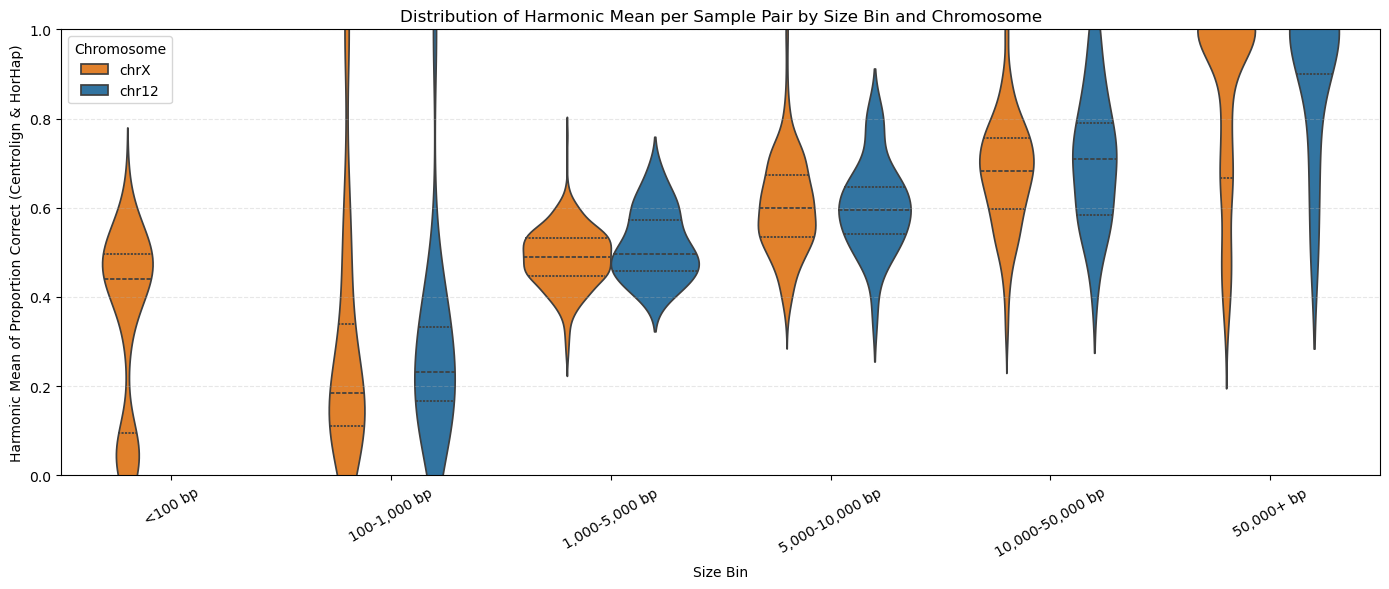

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure sample_pair exists
df_filtered['sample_pair'] = df_filtered.apply(
    lambda r: '_'.join(sorted([str(r['sample1_x']), str(r['sample2_x'])])),
    axis=1
)

# Create size bins
bins = [-float('inf'), 100, 1000, 5000, 10000, 50000, float('inf')]
labels = ['<100 bp', '100-1,000 bp', '1,000-5,000 bp', '5,000-10,000 bp',
          '10,000-50,000 bp', '50,000+ bp']

df_filtered['size_bin'] = pd.cut(df_filtered['size'], bins=bins, labels=labels)

# Compute proportion correct per row
df_filtered['prop_correct'] = (df_filtered['matched'] == 'correct').astype(float)

# Harmonic mean function
def harmonic_mean(vals):
    vals = np.array(vals)
    vals = vals[vals > 0]  # ignore zeros
    if len(vals) == 0:
        return np.nan
    return len(vals) / np.sum(1.0 / vals)

# Pivot to get Centrolign and HorHap per row
pair_wide = df_filtered.pivot_table(
    index=['chr', 'size_bin', 'sample_pair'],
    columns='label',
    values='prop_correct',
    aggfunc='mean'   # average over multiple rows if needed
).reset_index()

# Remove groups missing either label
pair_wide = pair_wide.dropna(subset=['Centrolign Only', 'HORHAP Only'])

# Compute harmonic mean of Centrolign and HorHap for each sample pair
pair_wide['harmonic_mean_ratio'] = pair_wide.apply(
    lambda r: harmonic_mean([r['Centrolign Only'], r['HORHAP Only']]),
    axis=1
)

# --- Violin plot ---
chr_order = ['chrX', 'chr12']
size_order = labels

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=pair_wide,
    x='size_bin',
    y='harmonic_mean_ratio',
    hue='chr',
    order=size_order,
    hue_order=chr_order,
    palette={'chrX': 'tab:orange', 'chr12': 'tab:blue'},
    split=False,
    inner='quartile'
)

plt.xlabel("Size Bin")
plt.ylabel("Harmonic Mean of Proportion Correct (Centrolign & HorHap)")
plt.title("Distribution of Harmonic Mean per Sample Pair by Size Bin and Chromosome")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Chromosome')
plt.tight_layout()
plt.show()

